# Meta Analysis of the Datasets for the Epi² pilot project 

---
# Subcellular cell localization datasets

---
# PYTHON 3 / R Notebook
### Adrien Leger / EMBL EBI
### Starting date 02/07/2016

---
## Import general package and definition of specific functions

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# pycl imports
from pycl import is_readable_file, is_gziped
from pycl import file_basename, file_extension, file_name, dir_name
from pycl import supersplit, rm_blank
from pycl import copyFile, gzip_file, gunzip_file
from pycl import head, linerange, colsum, fastcount, simplecount
from pycl import mkdir
from pycl import bash_basic, bash, make_cmd_str
from pycl import dict_to_md, dict_to_report
from pycl import reformat_table, _decompose_line, _clean_values, _reformat_line
from pycl import url_exist

#Std lib imports
import datetime
from glob import glob
from pprint import pprint as pp
from os.path import basename
from os import listdir, remove, rename
from os.path import abspath, basename, isdir
from collections import OrderedDict
import random
from math import *

# Third party import
import numpy as np
import scipy.stats as stats
import pylab as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#pyplot tweaking
%matplotlib inline
pl.rcParams['figure.figsize'] = 30, 10  # that's default image size for this interactive session

---
## Cabili = HT-FISH data

***Cabili, M. N. et al. Localization and abundance analysis of human lncRNAs at single-cell and single-molecule resolution. Genome Biol 16, (2015)***

- Subcellular Location of lncRNA by RNA FISH
- Nice dataset with Human foreskin fibloblast (hFFs), Human lung fibroblast (hLFs) and HeLA cells
- Limited to a very number of candidate = 34 only
- Could be a good control datasets if we stick to Hela cells

**The only data available are a large multitab excel file containing a lot of messy information. The annotation are based on different database (lncipedia or Noncode, or refSeq and rarely ensembl)... sometime the lncRNA is only described in one database and not in ensembl. First I obtained the common name for all lncRNA from lncipedia. However it was impossible to get the Ensembl equivalent in most of the cases.**

**Fortunatly they provide all the probe they used to fish the lncRNA. So when the information is not available I have to blast the probe in Ensemble to get the proper gene corresponding to the probes... It is a long and painfull work, but this dataset is going to be my reference for future localization experient so it has to be done properly**

In [6]:
d = OrderedDict()

for line in open("./Localisation_Original_Datasets/Cabili_RNA_FISH/probes_seq/All_probes.csv", 'r'):
    sequence, seq_name, gene_num = line.split("\t")
    d[gene_num]=seq_name.rpartition("_")[0]

for k,v in d.items():
    print ("{}\t{}".format(k.strip(),v))

1	XLOC_004198
2	XLOC_009233
3	NR_024412
4	NM_000272
5	XLOC_004456
6	NR_015370
7	XLOC_I2_010926
8	NR_024031
9	NR_038322
10	NR_027063
11	XLOC_009474
12	XLOC_004198
13	XLOC_009233
14	NR_024412
15	NM_000272
16	XLOC_004456
17	NR_015370
18	XLOC_I2_010926
19	NR_024031
20	NR_038322
21	NR_027063
22	XLOC_009474
23	XLOC_L2_008203
24	XLOC_012564
25	XLOC_012197
26	XLOC_012046_(exonsuniquetoNR_036444)
27	XLOC_011264
28	XLOC_010709
29	XLOC_010556
30	XLOC_009702
31	XLOC_009662
32	XLOC_009447
33	XLOC_008583
34	XLOC_008174
35	XLOC_005764
36	XLOC_005151
37	XLOC_004803
38	XLOC_004122
39	XLOC_003526
40	XLOC_002408
41	XLOC_002094
42	XLOC_000304
43	NR_033857exons0-2
44	NM_139078(XLOC_010202_neighbor)
45	NM_023000(NR_029435_neighbor)
46	XLOC_013841
47	XLOC_012046(exonsuniquetoNR_033925)
48	XLOC_010263
49	NM_005853(XLOC_011950_neighbor)
50	NM_000820_neighbor_of_XLOC_010514
51	ANCR
52	lincFOXF1
53	lincSFPQ
54	lincDR1
55	lincTUG1
56	lincGARS
57	lincMKLN1_A
58	ANRil
59	GAS5
60	Kcnq1ot1
61	Meg3
62	NR_033857(part n

In [17]:
# Extract the sequences of the probles for each gene in a separate file
def get_fasta_probes(infile, outfile, id_list=[]):
    
    seq_dict = OrderedDict()
    for line in open (infile, "r"):
        sequence, seq_name, gene_num = line.split("\t")
        gene_name, sep, seq_num = seq_name.rpartition("_")
        
        for id in id_list:
            if (type(id) == int and id == int(gene_num)) or (type(id) == str and id == gene_id):
                seq_dict[seq_name] = sequence

    # if sequences were found = write the a maximum of 30 randomly picked sequence in an outfile
    if seq_dict:
        key_list = list(seq_dict.keys())
        random.shuffle(key_list)
        
        with open (outfile, "w") as fp:
            for key in key_list[0:30]:
                fp.write(">{}\n{}\n".format(key, seq_dict[key]))

In [18]:
infile = "./Localisation_Original_Datasets/Cabili_RNA_FISH/probes_seq/All_probes.csv"

# Creating a file contaning the probe used for each 34 valid experimental designs
d ={"DANCR":[51, 8, 19],
    "CDKN2B-AS1":[58],
    "GAS5":[59],
    "KCNQ1OT1":[60],
    "FENDRR":[26, 47, 52, 95],
    "LINC-PINT":[57],
    "lnc-SFPQ-2":[53],
    "MALAT1":[92],
    "MEG3":[61],
    "NEAT1":[64],
    "LINC00998":[3, 14],
    "PSMA3-AS1":[85],
    "lnc-AC078802.1-2":[65],
    "TUG1":[55],
    "XIST":[67],
    "lnc-NRXN1-2":[41],
    "LINC01116":[40],
    "DUBR":[73],
    "lnc-GRXCR1-4":[39],
    "TMEM161B-AS1":[5, 16],
    "lnc-C5orf39-2":[37],
    "lnc-RREB1-4":[36],
    "LINC00472":[35],
    "PVT1":[72],
    "LINC01278":[34],
    "RAB30-AS1":[2, 13],
    "LINC00941":[30],
    "lnc-MAGOHB-1":[77],
    "GAS6-AS2":[82],
    "lnc-SNURF-1":[84],
    "OIP5-AS1":[68],
    "CRNDE":[74],
    "lnc-USP14-2":[76,87],
    "MIR4435-2HG":[23]}

for gene_name, id_list in d.items():
    outfile = "./Localisation_Original_Datasets/Cabili_RNA_FISH/probes_seq/Cabili_{}.fa".format(gene_name)
    get_fasta_probes(infile, outfile, id_list)
    print ("Created " + outfile)

Created ./Localisation_Original_Datasets/Cabili_RNA_FISH/probes_seq/Cabili_lnc-USP14-2.fa
Created ./Localisation_Original_Datasets/Cabili_RNA_FISH/probes_seq/Cabili_MIR4435-2HG.fa
Created ./Localisation_Original_Datasets/Cabili_RNA_FISH/probes_seq/Cabili_lnc-MAGOHB-1.fa
Created ./Localisation_Original_Datasets/Cabili_RNA_FISH/probes_seq/Cabili_MEG3.fa
Created ./Localisation_Original_Datasets/Cabili_RNA_FISH/probes_seq/Cabili_lnc-NRXN1-2.fa
Created ./Localisation_Original_Datasets/Cabili_RNA_FISH/probes_seq/Cabili_TMEM161B-AS1.fa
Created ./Localisation_Original_Datasets/Cabili_RNA_FISH/probes_seq/Cabili_CDKN2B-AS1.fa
Created ./Localisation_Original_Datasets/Cabili_RNA_FISH/probes_seq/Cabili_lnc-C5orf39-2.fa
Created ./Localisation_Original_Datasets/Cabili_RNA_FISH/probes_seq/Cabili_TUG1.fa
Created ./Localisation_Original_Datasets/Cabili_RNA_FISH/probes_seq/Cabili_KCNQ1OT1.fa
Created ./Localisation_Original_Datasets/Cabili_RNA_FISH/probes_seq/Cabili_lnc-AC078802.1-2.fa
Created ./Localisat

** Each file was blasted against ensembl human genomic sequence hgrh38. I manually checked the overlapping genes and the position of hits relative to exons. Finally I reported the corresponding ensembl ID. In 2 conditions I was nor able to find a gene in the ensembl build at the position indicated by the probes. Instead in fond genes only described in NCBI genes. Trom what I saw in the blast results, all of the genes identified are not lncRNA. I compared the ensembl gene ID found with the gencodev23 file containing all the genes. Results are summarized in the table thereafter**

In [132]:
def parse_ensembl_annotation (annotation_file):

    annotation_dict = OrderedDict()
    # Ensembl gen decomposing template
    template=[0,"\t",1,"\t",2,"\t",3,"\t",4,"\t",5,"\t",6,"\t",7,"\tID=",8,";gene_id=",9,";gene_type=",10,
              ";gene_status=",11,";gene_name=",12,";level=",13,";havana_gene=",14]
    
    # Parsing annotation file in a dict
    with open (annotation_file, "r") as fp:
        for line in fp:
            if line[0] != "#":
                sl = _decompose_line(line, template)       
                if sl[2] == "gene":
                    id = sl[8].split(".")[0]
                    assert id not in annotation_dict, "Duplicated gene ID !! Fuck" 
                    annotation_dict[id] = {
                        "seqid":sl[0],"source":sl[1],"type":sl[2],"start":sl[3],"end":sl[4],"score":sl[5],
                        "strand":sl[6],"phase":sl[7],"ID":sl[8],"gene_id":sl[9],"gene_type":sl[10],
                        "gene_status":sl[11],"gene_name":sl[12],"level":sl[13],"havana_gene":sl[14]}
    
    return annotation_dict

def annotate_ensembl_ID (annotation_file, candidate_file, out_file):
    
    print ("Parsing annotation file ...")
    annotation_dict = parse_ensembl_annotation(annotation_file)
    
    print ("Searching for candidates ...")
    with open (candidate_file, "r") as cf, open (out_file, "w") as of:
        of.write("#Gen_screenID\tGene_name\tEnsemb_ID\tseqid\tsource\ttype\tstart\tend\tscore\tstrand\tphase\tID\tgene_id\tgene_type\tgene_status\tgene_name\tlevel\thavana_gene\n")                
        
        for line in cf:
            if line[0] != "#":
                line = line.strip()
                sl= line.split("\t")           
                if sl[2] in annotation_dict:
                    of.write ("{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\n".format(
                            line,
                            annotation_dict[sl[2]]["seqid"].strip(),
                            annotation_dict[sl[2]]["source"].strip(),
                            annotation_dict[sl[2]]["type"].strip(),
                            annotation_dict[sl[2]]["start"].strip(),
                            annotation_dict[sl[2]]["end"].strip(),
                            annotation_dict[sl[2]]["score"].strip(),
                            annotation_dict[sl[2]]["strand"].strip(),
                            annotation_dict[sl[2]]["phase"].strip(),
                            annotation_dict[sl[2]]["ID"].strip(),
                            annotation_dict[sl[2]]["gene_id"].strip(),
                            annotation_dict[sl[2]]["gene_type"].strip(),
                            annotation_dict[sl[2]]["gene_status"].strip(),
                            annotation_dict[sl[2]]["gene_name"].strip(),
                            annotation_dict[sl[2]]["level"].strip(),
                            annotation_dict[sl[2]]["havana_gene"].strip()))
                else:
                    of.write ("{}\t{}\n".format(line, "NOT_FOUND"))                   

In [134]:
# Request annotation for all candidates in lncRNA Gencode database
annotation_file = "../Reference_Annotation/gencode_v24_lncRNAs_gene.gff3"
candidate_file = "./Localisation_Original_Datasets/Cabili_RNA_FISH/candidate_list.csv"
out_file = "./Localisation_Original_Datasets/Cabili_RNA_FISH/candidate_list_annotated.csv"
annotate_ensembl_ID (annotation_file, candidate_file, out_file)

head(out_file, 5)

Parsing annotation file ...
Searching for candidates ...
#Gen_screenID	Gene_name	Ensemb_ID	seqid	source	type	start	end	score	strand	phase	ID	gene_id	gene_type	gene_status	gene_name	level	havana_gene
ANCR	DANCR	ENSG00000226950	chr4	HAVANA	gene	52712404	52720351	.	+	.	ENSG00000226950.6	ENSG00000226950.6	processed_transcript	KNOWN	DANCR	2;tag=ncRNA_host	OTTHUMG00000154670.3
Anril	CDKN2B-AS1	ENSG00000240498	chr9	HAVANA	gene	21994778	22121097	.	+	.	ENSG00000240498.6	ENSG00000240498.6	antisense	KNOWN	CDKN2B-AS1	1;tag=ncRNA_host	OTTHUMG00000019689.3
GAS5	GAS5	ENSG00000234741	chr1	HAVANA	gene	173863900	173868882	.	-	.	ENSG00000234741.7	ENSG00000234741.7	processed_transcript	KNOWN	GAS5	2	OTTHUMG00000037216.5
Kcnq1ot1	KCNQ1OT1	ENSG00000269821	chr11	HAVANA	gene	2608328	2699994	.	-	.	ENSG00000269821.1	ENSG00000269821.1	antisense	KNOWN	KCNQ1OT1	2	OTTHUMG00000171022.2


In [138]:
# Request annotation for all candidates in all Gencode database
annotation_file = "../Reference_Annotation/gencode_v24_gene.gff3"
candidate_file = "./Localisation_Original_Datasets/Cabili_RNA_FISH/candidate_list.csv"
out_file = "./Localisation_Original_Datasets/Cabili_RNA_FISH/candidate_list_annotated.csv"
annotate_ensembl_ID (annotation_file, candidate_file, out_file)

head(out_file, 5)

Parsing annotation file ...
Searching for candidates ...
#Gen_screenID	Gene_name	Ensemb_ID	seqid	source	type	start	end	score	strand	phase	ID	gene_id	gene_type	gene_status	gene_name	level	havana_gene
ANCR	DANCR	ENSG00000226950	chr4	HAVANA	gene	52712404	52720351	.	+	.	ENSG00000226950.6	ENSG00000226950.6	processed_transcript	KNOWN	DANCR	2;tag=ncRNA_host	OTTHUMG00000154670.3
Anril	CDKN2B-AS1	ENSG00000240498	chr9	HAVANA	gene	21994778	22121097	.	+	.	ENSG00000240498.6	ENSG00000240498.6	antisense	KNOWN	CDKN2B-AS1	1;tag=ncRNA_host	OTTHUMG00000019689.3
GAS5	GAS5	ENSG00000234741	chr1	HAVANA	gene	173863900	173868882	.	-	.	ENSG00000234741.7	ENSG00000234741.7	processed_transcript	KNOWN	GAS5	2	OTTHUMG00000037216.5
Kcnq1ot1	KCNQ1OT1	ENSG00000269821	chr11	HAVANA	gene	2608328	2699994	.	-	.	ENSG00000269821.1	ENSG00000269821.1	antisense	KNOWN	KCNQ1OT1	2	OTTHUMG00000171022.2


**The 2 non-Ensembl lncRNA were not matched. As for the other 29 belong to the lncRNA class (processed_transcript, antisense, lincRNA), 1 is protein_coding and 2 are transcribed_unprocessed_pseudogene that do no belong to the lncRNA class. I think I will still keep a track of the pseudogene, since thay could also have a particular interest later in the analysis. So I have a final number of 29 valid lncRNA + 3 pseudogenes in the final dataset**

|#Gen_screenID|Gene_name|Ensemb_ID|gene_type|lncRNA_class|seqid|start|end|strand|
|---|---|---|---|---|---|---|---|---|
|ANCR|DANCR|ENSG00000226950|processed_transcript|YES|chr4|52712404|52720351|+|
|Anril|CDKN2B-AS1|ENSG00000240498|antisense|YES|chr9|21994778|22121097|+|
|GAS5|GAS5|ENSG00000234741|processed_transcript|YES|chr1|173863900|173868882|-|
|Kcnq1ot1|KCNQ1OT1|ENSG00000269821|antisense|YES|chr11|2608328|2699994|-|
|XLOC_012046|FENDRR|ENSG00000268388|lincRNA|YES|chr16|86474529|86509099|-|
|lincMKLN1_A1|LINC-PINT|ENSG00000231721|antisense|YES|chr7|130941760|131110176|-|
|lincSFPQ|SFPQ|ENSG00000116560|protein_coding|NO|chr1|35176378|35193148|-|
|MALAT1|MALAT1|ENSG00000251562|lincRNA|YES|chr11|65497762|65506516|+|
|Meg3|MEG3|ENSG00000214548|lincRNA|YES|chr14|100779410|100861031|+|
|NEAT1|NEAT1|ENSG00000245532|lincRNA|YES|chr11|65422774|65445540|+|
|NR_024412|LINC00998|ENSG00000214194|lincRNA|YES|chr7|113116718|113118613|-|
|NR_029435|PSMA3-AS1|ENSG00000257621|antisense|YES|chr14|58265365|58298134|-|
|TERC|TERC|ENSG00000270141|lincRNA|YES|chr3|169764520|169765060|-|
|XLOC_014209|TUG1|ENSG00000253352|antisense|YES|chr22|30970677|30979395|+|
|XLOC_008185|XIST|ENSG00000229807|lincRNA|YES|chrX|73820651|73852753|-|
|XLOC_002094|AC007682.1|ENSG00000231918|lincRNA|YES|chr2|51032601|52407917|+|
|XLOC_002408|LINC01116|ENSG00000163364|lincRNA|YES|chr2|176629589|176637931|-|
|XLOC_002746|DUBR|ENSG00000243701|lincRNA|YES|chr3|107240692|107326964|+|
|XLOC_003526|RP11-1E6.1|ENSG00000250657|processed_transcript|YES|chr4|43340875|43345600|+|
|XLOC_004456|TMEM161B-AS1|ENSG00000247828|antisense|YES|chr5|88268895|88436685|+|
|XLOC_004803|REFSEQ-FLJ32255|LOC643977|NA|NA|NA|NA|NA|NA|
|XLOC_005151|NCBI-105374902|LOC105374902|NA|NA|NA|NA|NA|NA|
|XLOC_005764|LINC00472|ENSG00000233237|lincRNA|YES|chr6|71344344|71420769|-|
|XLOC_006922|PVT1|ENSG00000249859|lincRNA|YES|chr8|127794533|128101253|+|
|XLOC_008174|LINC01278|ENSG00000235437|processed_transcript|YES|chrX|63343227|63561071|-|
|XLOC_009233|RAB30-AS1|ENSG00000246067|lincRNA|YES|chr11|83072066|83106719|+|
|XLOC_009702|LINC00941|ENSG00000235884|lincRNA|YES|chr12|30795681|30802711|+|
|XLOC_010017|KLRAP1|ENSG00000256667|transcribed_unprocessed_pseudogene|NO|chr12|10588063|10599669|-|
|XLOC_010514|GAS6-AS2|ENSG00000272695|lincRNA|YES|chr13|113864168|113866833|+|
|XLOC_011185|SNHG14|ENSG00000224078|processed_transcript|YES|chr15|24978583|25419462|+|
|XLOC_011226|OIP5-AS1|ENSG00000247556|processed_transcript|YES|chr15|41283990|41309737|+|
|XLOC_011950|CRNDE|ENSG00000245694|lincRNA|YES|chr16|54918863|54929189|-|
|XLOC_012599|ROCK1P1|ENSG00000263006|transcribed_unprocessed_pseudogene|NO|chr18|109065|122219|+|
|XLOC_L2_008203|MIR4435-2HG|ENSG00000172965|lincRNA|YES|chr2|111196350|111495100|-|



**I removed the data from the protein coding and non ensembl gene and crosmatch them with the experimental data in a simple 3 column csv file (Ensembl-ID : Cell type : localization code). I will create a bedfile containing the coordinate of the gene with additional information fetched from the gencodev23 annotation file. The idea is to obtain a standardize file similar to the bed file created previously for PTM.**

In [156]:
def Bed_ensembl_ID (annotation_file, localization_file, out_file):
        
    print ("Parsing annotation file ...")
    annotation_dict = parse_ensembl_annotation(annotation_file)
    
    h = "# Data cleaned, converted to BED6, standardized, hg38 coordinates\n"
    h+= "# Gene annotation scrapped from gencodev23\n"
    h+= "# Adrien Leger (aleg@ebi.ac.uk) {}\n".format(str (datetime.datetime.today()))
    h+= "# Localization type is a numeric code from the original publication\n"
    h+= "# 0 = Invalid detection\n"
    h+= "# 1 = One or 2 large nuclear foci\n"
    h+= "# 2 = Large nuclear foci and single molecules scattered through the nucleus\n"
    h+= "# 3 = Predominantly nuclear, without foci\n"
    h+= "# 4 = Cytoplasmic and nuclear\n"
    h+= "# 5 = Predominantly cytoplasmic\n"
    h+= "# chrom\tchromstart\tchromend\tLocalization_code|cell_type|method|PMID|ensembl_id|gene_type|gene_name\tscore\tstrand\n"
        
    print ("Searching for candidates ...")
    with open (localization_file, "r") as infile, open (out_file, "w") as outfile:
        outfile.write(h)
        total = invalid_loc_code = invalid_ensemble_id = 0
        
        for line in infile:
            if line[0] != "#":
                total+=1        
                sl= line.split("\t")
                ensemble_id = sl[0].strip()
                cell_type = sl[1].strip()
                loc_code = sl[2].strip()
                
                if loc_code == '0':
                    invalid_loc_code+=1
                    continue
                
                if ensemble_id not in annotation_dict:
                    invalid_ensemble_id+=1
                    continue
                    
                outfile.write ("{0}\t{1}\t{2}\t{3}|{4}|{5}|{6}|{7}|{8}|{9}\t{10}\t{11}\n".format(
                    annotation_dict[ensemble_id]["seqid"].strip(),
                    annotation_dict[ensemble_id]["start"].strip(),
                    annotation_dict[ensemble_id]["end"].strip(),
                    loc_code,
                    cell_type,
                    "RNA_FISH",
                    "25630241",
                    ensemble_id,
                    annotation_dict[ensemble_id]["gene_type"].strip(),
                    annotation_dict[ensemble_id]["gene_name"].strip(),
                    "-",
                    annotation_dict[ensemble_id]["strand"].strip()))
    
    print("Total: {}\tInvalid Localization code: {}\tInvalid Ensembl ID: {}".format(total,invalid_loc_code,invalid_ensemble_id))
                                   

In [158]:
# Request annotation for all candidates in all Gencode database (pseudogenes + lncRNA)
annotation_file = "../Reference_Annotation/gencode_v24_gene.gff3"
localization_file = "./Localisation_Original_Datasets/Cabili_RNA_FISH/Localization_cell_ensembl.csv"
out_file = "./Localisation_Clean_Datasets/Cabili_RNA_FISH_hg38.bed"

Bed_ensembl_ID (annotation_file, localization_file, out_file)

head (out_file, 15)

Parsing annotation file ...
Searching for candidates ...
Total: 93	Invalid Localization code: 24	Invalid Ensembl ID: 0
# Data cleaned, converted to BED6, standardized, hg38 coordinates
# Gene annotation scrapped from gencodev23
# Adrien Leger (aleg@ebi.ac.uk) 2016-06-15 17:58:10.405934
# Localization type is a numeric code from the original publication
# 0 = Invalid detection
# 1 = One or 2 large nuclear foci
# 2 = Large nuclear foci and single molecules scattered through the nucleus
# 3 = Predominantly nuclear, without foci
# 4 = Cytoplasmic and nuclear
# 5 = Predominantly cytoplasmic
# chrom	chromstart	chromend	Localization_code|cell_type|method|PMID|ensembl_id|gene_type|gene_name	score	strand
chr4	52712404	52720351	4|hela|RNA_FISH|25630241|ENSG00000226950|processed_transcript|DANCR	-	+
chr4	52712404	52720351	4|hLF|RNA_FISH|25630241|ENSG00000226950|processed_transcript|DANCR	-	+
chr4	52712404	52720351	4|hFF|RNA_FISH|25630241|ENSG00000226950|processed_transcript|DANCR	-	+
chr9	2199477

**This last step removed 24 lines out of 93 for genes that had a invalid localization code (0). The data are now stored in a Bed compatible dataset and ready to be used. I am done with this dataset.**

## Djebali =  ENCODE RNA-Seq nuclear/cytoplasmic fractions

### Exploration of the data space

**I just found this new extensive dataset from the ENCODE v2 consortium published in 2012 with RNA-Seq data from various human cell lines in the nucleus and in the cytoplasm. The data were analysed with the previous version of the human genome and would probably have to be remapped completly on the new version of the genome hg38 and using the last GENCODE annotations. I for each cell line I will compare the nuclear vs the cytoplasmic fractions to get the transcript significantly enriched in the nucleus vs the cytoplasm.**

**The content of the dataset is listed bellow** 

**Cell types (include immortalized cell lines, primary cells and embryonic cells)**
* A549
* GM12878
* H1-hESC
* HeLa-S3
* HepG2
* HUVEC
* IMR90
* K562
* MCF-7
* NHEK
* SK-N-SH

**Localization**
* Nucleus / Cytoplasm > Separated using Qiagen RLN buffer
* Cytosol
* Chromatin (K562 only)
* Nucleolus (K562 only)
* Nucleoplasm (K562 only)

** Additional informations**
* RNAs of >200 nt length are selected using the RNeasy MiniElute Cleanup kit
* RNA were split in 2 fractions by polyA + and the polyA - using Oligotex 
* All fractions were pre‐treated with the Ribominus Eukaryotic Kit for RNA‐seq
* PhiX was added at 1% in 
* There are 2 biological replicates for all the samples (except the H1-hESC embyonic cells)
* fastq Paired end reads are in 2 separates files
* bed, Bigwig, sam .. are also available but I only need the fastq since I will remap the data

** Summary of the dataset I will focus on** 

|Cell Line|Localization|RNA Extract|ENCODE Accesion|
|---|---|---|---|
|A549|cytosol|Long PolyA+ RNA|EH002624|
|A549|nucleus|Long PolyA+ RNA|EH002625|
|GM12878|cytosol|Long PolyA+ RNA|EH000147|
|GM12878|nucleus|Long PolyA+ RNA|EH000170|
|H1-hESC|cytosol|Long PolyA+ RNA|EH000151|
|H1-hESC|nucleus|Long PolyA+ RNA|EH000152|
|HeLa-S3|cytosol|Long PolyA+ RNA|EH000171|
|HeLa-S3|nucleus|Long PolyA+ RNA|EH000172|
|HepG2|cytosol|Long PolyA+ RNA|EH000161|
|HepG2|nucleus|Long PolyA+ RNA|EH000158|
|HUVEC|cytosol|Long PolyA+ RNA|EH000156|
|HUVEC|nucleus|Long PolyA+ RNA|EH000157|
|IMR90|cytosol|Long PolyA+ RNA|EH002626|
|IMR90|nucleus|Long PolyA+ RNA|EH002628|
|K562|cytosol|Long PolyA+ RNA|EH000140|
|K562|nucleus|Long PolyA+ RNA|EH000174|
|MCF-7|cytosol|Long PolyA+ RNA|EH002633|
|MCF-7|nucleus|Long PolyA+ RNA|EH002627|
|NHEK|cytosol|Long PolyA+ RNA|EH000166|
|NHEK|nucleus|Long PolyA+ RNA|EH000165|
|SK-N-SH|cytosol|Long PolyA+ RNA|EH002630|
|SK-N-SH|nucleus|Long PolyA+ RNA|EH002631|

### Reference cleaning and Index generation with Kallisto

**It has been a while that I want to use Kalisto, the software designed by Lior Patcher's team to analyse RNA data. I will perform this analysis with the conventional pipeline (STAR) in parallel to compare the results. The data are quite massive, so I will just prototype on my laptop but run the final analysis on the cluster**

**I dl the last reference fasta transcriptome for all RNA and for lncRNA only from the gencode server (v23). I need to clean the fasta Reference sequence from Gencode since they contain a lot of information from the transcript names of each sequences that will hamper the readability of the results. In order to be able to use the gene names and information later; I also need to save all the information contained in the names in a separate file.**  

In [6]:
from gzip import open as gopen

def Gencode_fastaclean_listinfo (gencode_fasta, clean_fasta="gencode_clean.fa.gz", gencode_info="gencode_info.tsv"):
    with gopen (gencode_fasta, "rt") as fasta_in, gopen (clean_fasta, "wt") as fasta_out, open (gencode_info, "wt") as info:
        
        # write header in the info file
        info.write ("{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\n".format(
            "GENCODE_transcript_id", "GENCODE_gene_id", "HAVANA_gene_id", "HAVANA_transcript_id", "transcript_name",
            "gene_name", "length", "RNA_type"))
        
        nline = nseq = 0
        for line in fasta_in:
            nline += 1
            
            if line[0] == ">":
                nseq += 1
                ls = [i.strip() for i in line[1:].split("|")]
                fasta_out.write (">{}\n".format(ls[0]))
                
                # in lncRNA file not RNA type at the end...
                if not ls[7]:
                    ls[7]="NA"
                info.write("\t".join(ls)+"\n")
            
            else:
                fasta_out.write(line)
    
    print ("Parsed {} lines\t Found {} Sequences".format(nline, nseq))

In [7]:
gencode_fasta = "../../Reference_Genomes/gencode.v24.lncRNA_transcripts.fa.gz"
clean_fasta = "../../Reference_Genomes/gencode_v24_lncRNA_transcripts_clean.fa.gz"
gencode_info = "../../Reference_Genomes/gencode_v24_lncRNA_transcripts_info.tsv"

print ("Clean the file and generate the list from IDs\n") 
Gencode_fastaclean_listinfo (gencode_fasta, clean_fasta, gencode_info)

print ("Visualize the result\n")
head(gencode_fasta, 2)
head(clean_fasta, 2)
head(gencode_info, 2)

Clean the file and generate the list from IDs

Parsed 56062 lines	 Found 28031 Sequences
Visualize the result

>ENST00000473358.1|ENSG00000243485.3|OTTHUMG00000000959.2|OTTHUMT00000002840.1|RP11-34P13.3-001|RP11-34P13.3|712|
GTGCACACGGCTCCCATGCGTTGTCTTCCGAGCGTCAGGCCGCCCCTACCCGTGCTTTCTGCTCTGCAGACCCTCTTCCTAGACCTCCGTCCTTTGTCCCATCGCTGCCTTCCCCTCAAGCTCAGGGCCAAGCTGTCCGCCAACCTCGGCTCCTCCGGGCAGCCCTCGCCCGGGGTGCGCCCCGGGGCAGGACCCCCAGCCCACGCCCAGGGCCCGCCCCTGCCCTCCAGCCCTACGCCTTGACCCGCTTTCCTGCGTCTCTCAGCCTACCTGACCTTGTCTTTACCTCTGTGGGCAGCTCCCTTGTGATCTGCTTAGTTCCCACCCCCCTTTAAGAATTCAATAGAGAAGCCAGACGCAAAACTACAGATATCGTATGAGTCCAGTTTTGTGAAGTGCCTAGAATAGTCAAAATTCACAGAGACAGAAGCAGTGGTCGCCAGGAATGGGGAAGCAAGGCGGAGTTGGGCAGCTCGTGTTCAATGGTTTTGTCCGCCTTCCCTGCCTCCTCTTCTGGGGGAGTTAGATCGAGTTGTAACAAGAACATGCCACTGTCTCGCTGGCTGCAGCGTGTGGTCCCCTTACCAGAGTGAGGATGCGAAGAGAAGGTGGCTGTCTGCAAACCAGGAAGAGAGCCCTCACCGGGAACCCGTCCAGCTGCCACCTTGAACTTGGACTTCCAAGCCTCCAGAACTGTGAGGGATAAATGTAT

>ENST00000473358.1
GTGCACACGGCTCCCATGCGTTGTCTTCCGAGCGTCAGGCCG

In [6]:
gencode_fasta = "../../Reference_Genomes/gencode.v24.transcripts.fa.gz"
clean_fasta = "../../Reference_Genomes/gencode_v24_transcripts_clean.fa.gz"
gencode_info = "../../Reference_Genomes/gencode_v24_transcripts_info.tsv"

print ("Clean the file and generate the list from IDs\n") 
Gencode_fastaclean_listinfo (gencode_fasta, clean_fasta, gencode_info)

print ("Visualize the result\n")
head(gencode_fasta, 2)
head(clean_fasta, 2)
head(gencode_info, 2)

Clean the file and generate the list from IDs

Parsed 398338 lines	 Found 199169 Sequences
Visualize the result

>ENST00000456328.2|ENSG00000223972.5|OTTHUMG00000000961.2|OTTHUMT00000362751.1|DDX11L1-002|DDX11L1|1657|processed_transcript|
GTTAACTTGCCGTCAGCCTTTTCTTTGACCTCTTCTTTCTGTTCATGTGTATTTGCTGTCTCTTAGCCCAGACTTCCCGTGTCCTTTCCACCGGGCCTTTGAGAGGTCACAGGGTCTTGATGCTGTGGTCTTCATCTGCAGGTGTCTGACTTCCAGCAACTGCTGGCCTGTGCCAGGGTGCAAGCTGAGCACTGGAGTGGAGTTTTCCTGTGGAGAGGAGCCATGCCTAGAGTGGGATGGGCCATTGTTCATCTTCTGGCCCCTGTTGTCTGCATGTAACTTAATACCACAACCAGGCATAGGGGAAAGATTGGAGGAAAGATGAGTGAGAGCATCAACTTCTCTCACAACCTAGGCCAGTGTGTGGTGATGCCAGGCATGCCCTTCCCCAGCATCAGGTCTCCAGAGCTGCAGAAGACGACGGCCGACTTGGATCACACTCTTGTGAGTGTCCCCAGTGTTGCAGAGGCAGGGCCATCAGGCACCAAAGGGATTCTGCCAGCATAGTGCTCCTGGACCAGTGATACACCCGGCACCCTGTCCTGGACACGCTGTTGGCCTGGATCTGAGCCCTGGTGGAGGTCAAAGCCACCTTTGGTTCTGCCATTGCTGCTGTGTGGAAGTTCACTCCTGCCTTTTCCTTTCCCTAGAGCCTCCACCACCCCGAGATCACATTTCTCACTGCCTTTTGTCTGCCCAGTTTCACCAGAAGTAGGCCTCTTCCTGACAGGCAGCTGCACCACTGCCTGGCGCTGTGCCCT

**To compare the different conditions it might be interesting to to use the internal spike in used in all ENCODE samples. The added the ERCC (External RNA Controls Consortium) RNA Spike-In Mix that is also sometime called NIST spike. This is a pool of 96 synthetic RNAs with various lengths, and GC content covering a 2^20 concentration range as spike-in controls to measure sensitivity, accuracy, and biases in RNA-seq experiments as well as to derive standard curves for quantifying the abundance of transcripts. In all the sample I have selected the used the ERCC pool 14 and the provide the concentration for all RNAs in a tsv file. To enable there analysis one should include the sequences of the oligo transcripts in the alignment step. I will generate a new reference mixing the human genome transcripts as well as the ERCC transcript directil on the computation farm**

**Create indexes for Kalisto from the human lncRNA and all RNA transcriptome gencode v23 including the ERCC spike-in transcripts that might be used for normalization later**

In [8]:
program = "kallisto-0.43 index"
index_dir = "../../Index/kallisto/"
index_name = "gencode_v24_lncRNA_transcripts_ERCC.idx"
index_report = "gencode_v24_lncRNA_transcripts_ERCC.txt"
gencode_fasta = "../../Reference_Genomes/gencode.v24.lncRNA_transcripts.fa.gz"
gencode_ERCC = "../../Reference_Genomes/ERCC.fa.gz"

mkdir(index_dir)

cmd = "{} -i {}{} {} {}".format(program, index_dir, index_name, gencode_fasta, gencode_ERCC)
print (cmd)

stderr = bash (cmd, ret_stderr=True, ret_stdout=False)
print (stderr)

# write the report
with open (index_dir+index_report, "w") as fp:
    fp.write(stderr)

kallisto-0.43 index -i ../../Index/kallisto/gencode_v24_lncRNA_transcripts_ERCC.idx ../../Reference_Genomes/gencode.v24.lncRNA_transcripts.fa.gz ../../Reference_Genomes/ERCC.fa.gz

[build] loading fasta file ../../Reference_Genomes/gencode.v24.lncRNA_transcripts.fa.gz
[build] loading fasta file ../../Reference_Genomes/ERCC.fa.gz
[build] k-mer length: 31
[build] warning: clipped off poly-A tail (longer than 10)
        from 305 target sequences
[build] warning: replaced 4 non-ACGUT characters in the input sequence
        with pseudorandom nucleotides
[build] counting k-mers ... done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence classes ...  done
[build] target de Bruijn graph has 154016 contigs and contains 21010527 k-mers 




In [9]:
program = "kallisto-0.43 index"
index_dir = "../../Index/kallisto/"
index_name = "gencode_v24_transcripts_ERCC.idx"
index_report = "gencode_v24_transcripts_ERCC.txt"
gencode_fasta = "../../Reference_Genomes/gencode.v24.transcripts.fa.gz"
gencode_ERCC = "../../Reference_Genomes/ERCC.fa.gz"

mkdir(index_dir)

cmd = "{} -i {}{} {} {}".format(program, index_dir, index_name, gencode_fasta, gencode_ERCC)
print (cmd)

stderr = bash (cmd, ret_stderr=True, ret_stdout=False)
print (stderr)

# write the report
with open (index_dir+index_report, "w") as fp:
    fp.write(stderr)

kallisto-0.43 index -i ../../Index/kallisto/gencode_v24_transcripts_ERCC.idx ../../Reference_Genomes/gencode.v24.transcripts.fa.gz ../../Reference_Genomes/ERCC.fa.gz

[build] loading fasta file ../../Reference_Genomes/gencode.v24.transcripts.fa.gz
[build] loading fasta file ../../Reference_Genomes/ERCC.fa.gz
[build] k-mer length: 31
[build] warning: clipped off poly-A tail (longer than 10)
        from 1629 target sequences
[build] warning: replaced 87 non-ACGUT characters in the input sequence
        with pseudorandom nucleotides
[build] counting k-mers ... done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence classes ...  done
[build] target de Bruijn graph has 1261145 contigs and contains 123979963 k-mers 




### Fastq files download 

**To analyse the data I will have to get all the fastq files and I will use the Cluster because of the amount of data to be analysed. All the data are available on the ENCODE website https://www.encodeproject.org/ and I can acces them thanks to the ENCODE Accesion number per experimental conditions. For each conditions I retrieved manually a file containing download links for all the files they generated. see bellow**

In [10]:
!cat ./Localisation_Original_Datasets/Djebali-ENCODE/ENCODE_sample_files/EH000140.txt

https://www.encodeproject.org/metadata/type=Experiment&y.limit=&searchTerm=EH000140/metadata.tsv
https://www.encodeproject.org/files/ENCFF000HIL/@@download/ENCFF000HIL.bigBed
https://www.encodeproject.org/files/ENCFF000HIM/@@download/ENCFF000HIM.gtf.gz
https://www.encodeproject.org/files/ENCFF000HIO/@@download/ENCFF000HIO.gtf.gz
https://www.encodeproject.org/files/ENCFF000HIS/@@download/ENCFF000HIS.bam
https://www.encodeproject.org/files/ENCFF000HIT/@@download/ENCFF000HIT.bam
https://www.encodeproject.org/files/ENCFF000HIU/@@download/ENCFF000HIU.gtf.gz
https://www.encodeproject.org/files/ENCFF000HIW/@@download/ENCFF000HIW.gtf.gz
https://www.encodeproject.org/files/ENCFF000HIY/@@download/ENCFF000HIY.gtf.gz
https://www.encodeproject.org/files/ENCFF000HJA/@@download/ENCFF000HJA.bigBed
https://www.encodeproject.org/files/ENCFF000HJB/@@download/ENCFF000HJB.bigWig
https://www.encodeproject.org/files/ENCFF000HJC/@@download/ENCFF000HJC.bigWig
https://www.encodeproject.org/files/ENCFF000HJD/@@d

**The first file contains a large table with detailled informations for all the files contained in the conditions including there download links I will parse each of the tables and extract only the information related to fastq files**

In [16]:
from urllib.request import urlopen

def parse_ENCODE_info_files(file_dir, tsv_outfile):

    # Handler to write the collect information
    with open (tsv_outfile, "w") as outfp:
        # Loop over the information files to extract the url of the tsv file 
        for f in sorted(glob(file_dir+"*.txt")):
            print("Parsing {}".format(file_basename(f)))
            with open(f) as infp:
                URL = next(infp).strip()

                # Parse the tsv url and extract the lines correponding to the fadtq files   
                with urlopen(URL) as tsv:
                    for line in tsv:
                        dl = line.decode('utf-8')
                        sl = dl.split("\t")

                        # Write the lines in the collecting file
                        if sl[1] == "fastq":
                            outfp.write(dl)
    return tsv_outfile

In [17]:
tsv_outfile = "./Localisation_Original_Datasets/Djebali-ENCODE/fastq/fastq_details.tsv"
file_dir = "./Localisation_Original_Datasets/Djebali-ENCODE/ENCODE_sample_files/"

parse_ENCODE_info_files(file_dir, tsv_outfile)
print(fastcount(outfile))
head (outfile, 2)

Parsing EH000140
Parsing EH000147
Parsing EH000151
Parsing EH000152
Parsing EH000156
Parsing EH000157
Parsing EH000158
Parsing EH000161
Parsing EH000165
Parsing EH000166
Parsing EH000170
Parsing EH000171
Parsing EH000172
Parsing EH000174
Parsing EH002624
Parsing EH002625
Parsing EH002626
Parsing EH002627
Parsing EH002628
Parsing EH002630
Parsing EH002631
Parsing EH002633
84
ENCFF000HJF	fastq	reads	ENCSR000COK	RNA-seq	EFO:0002067	K562	immortalized cell line	adult	female	Homo sapiens		cytosol					polyadenylated mRNA	rRNA	see document	see document		2011-10-17	ENCODE		see document	>200	53 year	2	1	76	paired-ended	1	ENCFF000HJX		5848000346	Thomas Gingeras, CSHL	7d6fb0723fb5c2b48e40c6312fc9134e	https://www.encodeproject.org/files/ENCFF000HJF/@@download/ENCFF000HJF.fastq.gz		Illumina Genome Analyzer IIx
ENCFF000HJP	fastq	reads	ENCSR000COK	RNA-seq	EFO:0002067	K562	immortalized cell line	adult	female	Homo sapiens		cytosol					polyadenylated mRNA	rRNA	see document	see document		2011-10-17	ENCODE

**From this file containing all the information I will write a small python script to download the data on the cluster, similar to the following. https://github.com/a-slide/pyScripts/blob/master/EncodeParser.py. I launched the jobs on the cluster farm to download all the fastq files corresponding to the ENCODE number of Nucleus and cytosolic fraction polyA+ RNA. All the data are now available in the ebi server. There are 42 paired ended datafile. I renamed some of the datasets because *HUVEC* cells were called *endothelial-cell-of-umbilical-vein* and *NHEK* were called *keratinocyte* **

### Alignment with Kallisto quant

**Test alignement with 1M reads extracted from one of the ENCODE datasets with 4 threads, 5 bootstraps and in rf stranded mode**

In [5]:
program = "kallisto-0.43 quant"
index="../../Index/kallisto/gencode_v24_lncRNA_transcripts_ERCC.idx"
R1="./Localisation_Original_Datasets/Djebali-ENCODE/fastq/1M_test_R1.fastq.gz"
R2="./Localisation_Original_Datasets/Djebali-ENCODE/fastq/1M_test_R2.fastq.gz"
output_dir = "./Localisation_Original_Datasets/Djebali-ENCODE/kallisto/test/"
align_report = output_dir+"kallisto_report.txt"
n_thread = 4
n_bootstraps = 10

mkdir(output_dir)

cmd = "{} -t {} -b {} --fr-stranded -i {} -o {} {} {}".format(program, n_thread, n_bootstraps, index, output_dir, R1, R2)
print (cmd)

stderr = bash (cmd, ret_stderr=True, ret_stdout=False)
print (stderr)

# write the report
with open (align_report, "w") as fp:
    fp.write(stderr)

kallisto-0.43 quant -t 4 -b 10 --fr-stranded -i ../../Index/kallisto/gencode_v24_lncRNA_transcripts_ERCC.idx -o ./Localisation_Original_Datasets/Djebali-ENCODE/kallisto/test/ ./Localisation_Original_Datasets/Djebali-ENCODE/fastq/1M_test_R1.fastq.gz ./Localisation_Original_Datasets/Djebali-ENCODE/fastq/1M_test_R2.fastq.gz

[quant] fragment length distribution will be estimated from the data
[index] k-mer length: 31
[index] number of targets: 28,127
[index] number of k-mers: 21,010,527
[index] number of equivalence classes: 91,580
[quant] running in paired-end mode
[quant] will process pair 1: ./Localisation_Original_Datasets/Djebali-ENCODE/fastq/1M_test_R1.fastq.gz
                             ./Localisation_Original_Datasets/Djebali-ENCODE/fastq/1M_test_R2.fastq.gz
[quant] finding pseudoalignments for the reads ... done
[quant] processed 1,000,000 reads, 58,177 reads pseudoaligned
[quant] estimated average fragment length: 303.622
[   em] quantifying the abundances ... done
[   em] the

**Kalisto quant is working correctly and we obtain a file with counts directly in a very short time. However due to space and parralelisation concerns I will perform the dataset wide analyses on the cluster**

**The alignments against the modified reference containing both human transcripts were performed on the cluster. I performed 4 different aligments:**
* Against all gencode transcripts + ERCC transcripts with strand specific alignment 
* Against lncRNA gencode gencode transcripts + ERCC transcripts with strand specific alignment
* Against all gencode transcripts only with strand specific alignment 
* Against lncRNA gencode gencode transcripts only with strand specific alignment

**According to the Sleuth paper it might be beneficial perform 100 boostrap although they say that they don't really knows which is the minimun to obtain reliable results**

***kallisto quant --bias -b 100 --rf-stranded -t 4 -i INDEX -o OUTPUT_FOLDER READ1 READ2***

**I then copied the results localy for further analysis with Sleuth, since the size is rather small.**

In [8]:
# Parse the stderr files containing the number of read aligned with kallisto
sname_list=[]
tae=[] # total all RNA ERCC
mae=[] # mapped all RNA ERCC
tle=[] # total lncRNA ERCC
mle=[] # mapped lncRNA ERCC
ma=[] # mapped all RNA no ERCC
ml=[] # mapped lncRNA no ERCC
flen_list=[]

# results obtained with basic alignment using Kallisto quant
for file in glob("./Localisation_Original_Datasets/Djebali-ENCODE/kallisto/allRNA_ERCC/*/stderr.txt"):
    sname_list.append(file.split("/")[-2])   
    lines = !cat {file}
    flen_list.append(float(lines[12].split()[-1].replace(",","")))
    tae.append(int(lines[11].split()[2].replace(",","")))
    mae.append(int(lines[11].split()[4].replace(",","")))

# results obtained with stranded alignment using Kallisto quant
for file in glob("./Localisation_Original_Datasets/Djebali-ENCODE/kallisto/lncRNA_ERCC/*/stderr.txt"):
    lines = !cat {file}
    tle.append(int(lines[11].split()[2].replace(",","")))
    mle.append(int(lines[11].split()[4].replace(",","")))

# results obtained with stranded alignment using Kallisto quant
for file in glob("./Localisation_Original_Datasets/Djebali-ENCODE/kallisto/allRNA/*/stderr.txt"):
    lines = !cat {file}
    ma.append(int(lines[11].split()[4].replace(",","")))
    
# results obtained with stranded alignment using Kallisto quant
for file in glob("./Localisation_Original_Datasets/Djebali-ENCODE/kallisto/lncRNA/*/stderr.txt"):
    lines = !cat {file}
    ml.append(int(lines[11].split()[4].replace(",","")))

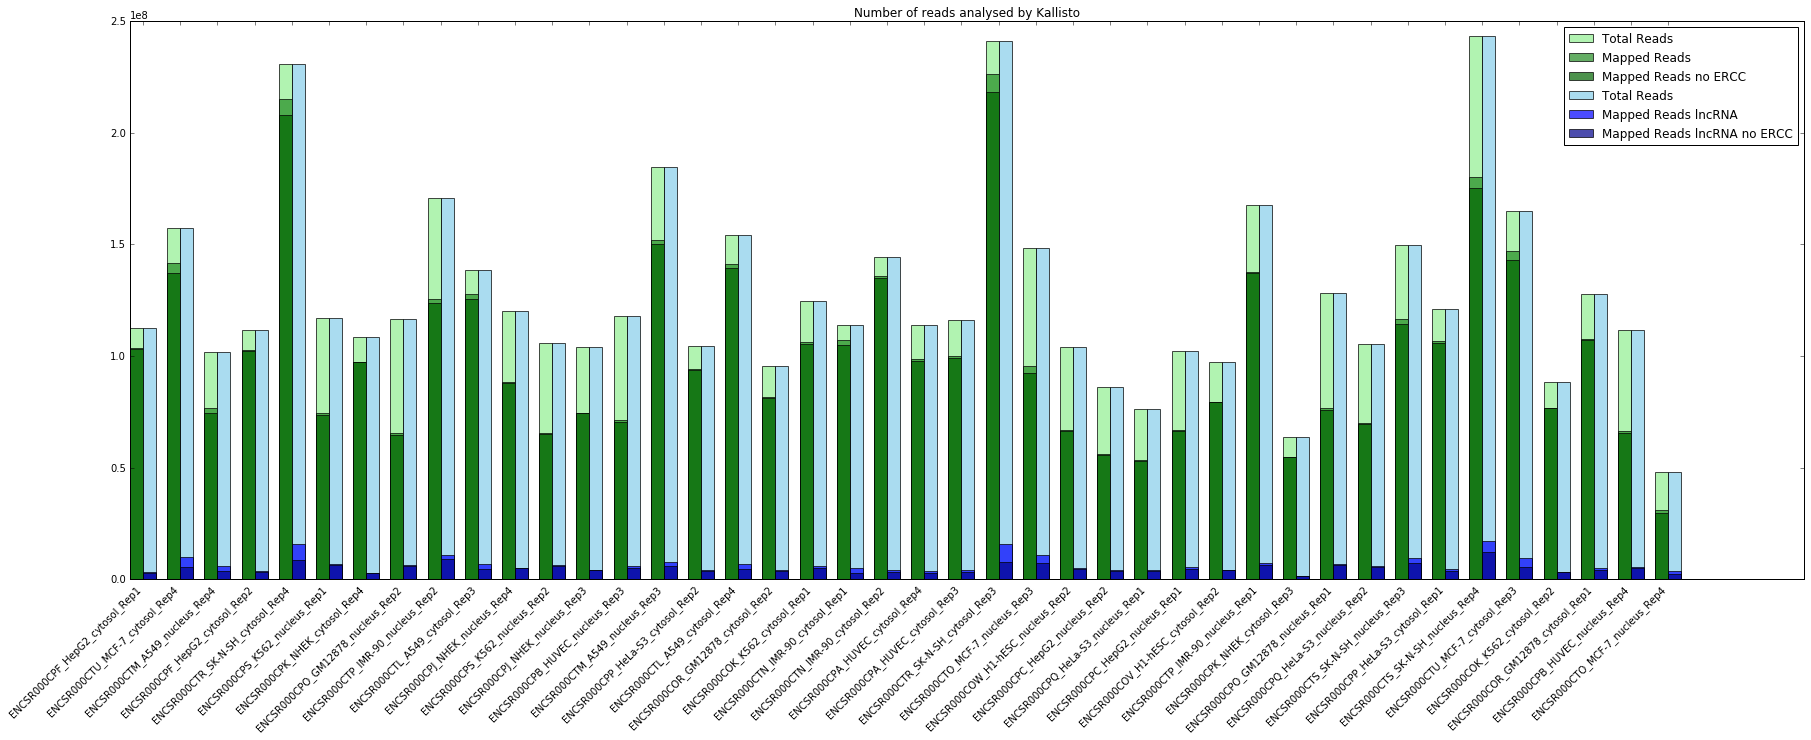

In [24]:
# Plot the results
index = np.arange(len(sname_list))
bar_width = 0.35

p0 = pl.bar(index, tae, bar_width, color="LightGreen", alpha=0.7)
p1 = pl.bar(index, mae, bar_width, color="ForestGreen", alpha=0.7)
p2 = pl.bar(index, ma, bar_width, color="DarkGreen", alpha=0.7)
p3 = pl.bar(index+bar_width, tle, bar_width, color="SkyBlue", alpha=0.7)
p4 = pl.bar(index+bar_width, mle, bar_width, color="Blue", alpha=0.7)
p5 = pl.bar(index+bar_width, ml, bar_width, color="DarkBlue", alpha=0.7)

pl.xticks(index+bar_width, sname_list, rotation=45, horizontalalignment ="right")
pl.legend((p0[0], p1[0], p2[0], p3[0], p4[0], p5[0]), ('Total Reads', 'Mapped Reads','Mapped Reads no ERCC','Total Reads', 'Mapped Reads lncRNA','Mapped Reads lncRNA no ERCC'))
pl.title("Number of reads analysed by Kallisto")
pl.show()

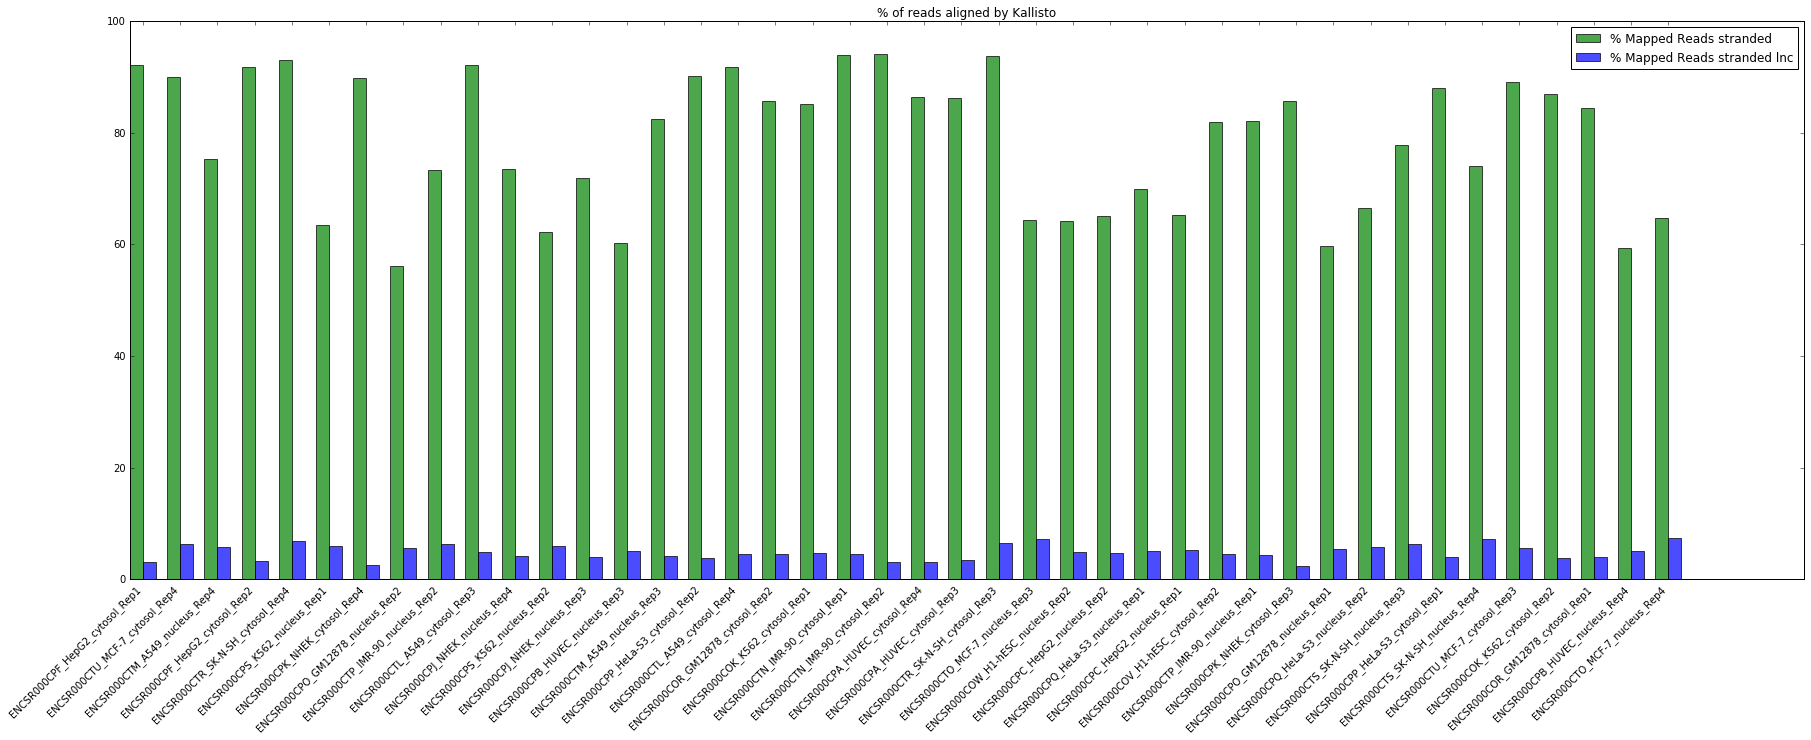

In [23]:
# Plot the results
index = np.arange(len(sname_list))
bar_width = 0.35

percent_unstrand = [mapped/total*100.0 for mapped, total in zip(mapped_list, total_list)]
percent_strand = [mapped/total*100.0 for mapped, total in zip(mapped_lnc_list, total_lnc_list)]
    
p1 = pl.bar(index, percent_unstrand, bar_width, color="green", alpha=0.7)
p2 = pl.bar(index+bar_width, percent_strand, bar_width, color="blue", alpha=0.7)

pl.xticks(index+bar_width, sname_list, rotation=45, horizontalalignment ="right")
pl.legend((p1[0], p2[0]), ('% Mapped Reads stranded', '% Mapped Reads stranded lnc'))
pl.title("% of reads aligned by Kallisto")
pl.show()

**I obtained between 4E7 and 2.3E8 reads aligned (ie 60% and 90%). The stranded alignment results in less aligned reads but it is surely more accurate, so I will use only these results. There are much fewer read aligned on lncRNA (< 10%) but this is consistant with previous knowledge**

### Sleuth differencial expression analysis

**For the analysis with Sleuth I will use the basic pipeline recommanded by the documentation https://rawgit.com/pachterlab/sleuth/master/inst/doc/intro.html. Apparently it is not possible to use the ERCC to normalize the tpm and est, since the bootstrap would also have to be normalized. Instead I will perform the analysis with the ERCC transcripts and will verify that they do not appear significantly differentially expressed. If so, the Sleuth normalization is certainly enough, else I would have to find another way to analyse kallisto data**

**Normalize the name of the replicates in the folder containing the samples which are sometime called Rep1 Re2p Rep3 or Rep4**

In [28]:
def normalize_repname(basedir):
    subst_dict = {"Rep1": "1", "Rep2": "2","Rep3": "1","Rep4": "2"}

    for subdir in [path for path in glob(basedir+"/*") if isdir(path)]:
        ss = subdir.split("_")
        if ss[-1] in subst_dict:
            ss[-1] = subst_dict[ss[-1]]
        newname = "_".join(ss)
        rename (subdir, newname)

In [37]:
for basedir in [
    "./Localisation_Original_Datasets/Djebali-ENCODE/kallisto/lncRNA/",
    "./Localisation_Original_Datasets/Djebali-ENCODE/kallisto/allRNA/",
    "./Localisation_Original_Datasets/Djebali-ENCODE/kallisto/lncRNA_ERCC/",
    "./Localisation_Original_Datasets/Djebali-ENCODE/kallisto/allRNA_ERCC/"
    ]:
    
    normalize_repname(basedir)
    !ls {basedir} | head -2


ENCSR000COK_K562_cytosol_1
ENCSR000COK_K562_cytosol_2
ENCSR000COK_K562_cytosol_1
ENCSR000COK_K562_cytosol_2
ENCSR000COK_K562_cytosol_1
ENCSR000COK_K562_cytosol_2
ENCSR000COK_K562_cytosol_1
ENCSR000COK_K562_cytosol_2


**Create a file containing the name of samples, the cell type, the localization and the path to the dir containing kallisto results** 

In [39]:
# general library import
from os.path import abspath, basename, isdir
from glob import glob

# Function ro parse each dir and  create a sample file
def sleuth_sample_list (basedir):
    
    list_file = basedir+"list_file.tsv"
    
    with open (list_file, "w") as outfp:
        outfp.write("sample\tcell_type\tlocalization\treplicate\tpath\n")

        for subdir in [path for path in glob(basedir+"/*") if isdir(path)]:
            ss = basename(subdir).split("_")
            outfp.write("{}\t{}\t{}\t{}\t{}\n".format ("_".join(ss), ss[1], ss[2], ss[3], abspath(subdir)))
    
    return list_file

In [40]:
for basedir in [
    "./Localisation_Original_Datasets/Djebali-ENCODE/kallisto/lncRNA/",
    "./Localisation_Original_Datasets/Djebali-ENCODE/kallisto/allRNA/",
    "./Localisation_Original_Datasets/Djebali-ENCODE/kallisto/lncRNA_ERCC/",
    "./Localisation_Original_Datasets/Djebali-ENCODE/kallisto/allRNA_ERCC/"
    ]:
    
    list_file = sample_list = sleuth_sample_list(basedir)
    head (list_file, 2)

sample	cell_type	localization	replicate	path
ENCSR000COW_H1-hESC_nucleus_2	H1-hESC	nucleus	2	/home/aleg/Data/Datasets/Epi2_pilot/Localisation_Original_Datasets/Djebali-ENCODE/kallisto/lncRNA/ENCSR000COW_H1-hESC_nucleus_2

sample	cell_type	localization	replicate	path
ENCSR000COW_H1-hESC_nucleus_2	H1-hESC	nucleus	2	/home/aleg/Data/Datasets/Epi2_pilot/Localisation_Original_Datasets/Djebali-ENCODE/kallisto/allRNA/ENCSR000COW_H1-hESC_nucleus_2

sample	cell_type	localization	replicate	path
ENCSR000COW_H1-hESC_nucleus_2	H1-hESC	nucleus	2	/home/aleg/Data/Datasets/Epi2_pilot/Localisation_Original_Datasets/Djebali-ENCODE/kallisto/lncRNA_ERCC/ENCSR000COW_H1-hESC_nucleus_2

sample	cell_type	localization	replicate	path
ENCSR000COW_H1-hESC_nucleus_2	H1-hESC	nucleus	2	/home/aleg/Data/Datasets/Epi2_pilot/Localisation_Original_Datasets/Djebali-ENCODE/kallisto/allRNA_ERCC/ENCSR000COW_H1-hESC_nucleus_2



**Define an R function to analyse data with Sleuth**

In [6]:
################## R KERNEL ##################

sleuth_analysis <- function(sample_list, transcript_info, select_col, select_val, de_col, beta_factor_list, outdir=".", ncore=4, max_bootstrap=10) {
    
    # Imports and setups
    library("sleuth")
    options(mc.cores = ncore)
 
    # Create the output directory
    outdir=file.path(outdir, select_val)
    dir.create(outdir, showWarnings = FALSE, recursive = TRUE)
    
    cat("IMPORT AND SELECT THE SAMPLES\n")   
    # Import the file in a table and select sample according to select val and col 
    s2c = read.table(sample_list, header = TRUE, stringsAsFactors=FALSE)
    s2c = s2c[s2c[,select_col] == select_val,]   
    print (s2c$sample)
    
    # Save the table in file for tracability
    fname = file.path(outdir,"selected_datasets.tsv")
    write.table(s2c, file = fname, sep="\t", col.names = TRUE)
    
    cat("IMPORT THE GENE INFORMATIONS\n")   
    # Import the gene info in table and rename the fields for Sleuth compatibility
    t2g = read.table(transcript_info, header = TRUE, stringsAsFactors=FALSE)
    t2g = dplyr::rename(t2g, target_id = GENCODE_transcript_id, ens_gene = GENCODE_gene_id)
    
    cat("PREPARE THE DATA FOR SLEUTH\n")   
    # Extract the data from the kallisto results, LIMIT to 3 because for 100 the kernel get killed !!
    de_formula = as.formula(paste("~", de_col))
    so = sleuth_prep(s2c, de_formula, max_bootstrap=max_bootstrap, target_mapping = t2g)

    cat("FIT TO FULL MODEL\n")  
    # Estimate parameters for the sleuth response error measurement (full) model
    so <- sleuth_fit(so)
    
    cat("FIT TO REDUCED MODEL\n")
    # Estimate parameters for the sleuth reduced model (shrinkage)
    so <- sleuth_fit(so, ~1, 'reduced')

    cat("PERFORM WALD TESTING\n")
    # Performing Wald test
    for (beta_factor in beta_factor_list) { so <- sleuth_wt(so, which_beta = beta_factor, 'full')}

    cat("PERFORM LIKELYHOOD RATION TESTING\n")
    # Perform likelihood ratio test
    so <- sleuth_lrt(so, 'reduced', 'full')
    
    cat("EXPORT RESULTS")
    # Save all the raw abundance results in a table
    fname = file.path(outdir, "abundance_raw.tsv")
    write.table(so$obs_raw, file = fname, row.names=FALSE, na="",col.names=TRUE, sep="\t", quote=FALSE)
    # Save all the normalised abundance results in a table
    fname = file.path(outdir, "abundance_normed.tsv")
    write.table(so$obs_norm, file = fname, row.names=FALSE, na="",col.names=TRUE, sep="\t", quote=FALSE)
    # Save all the normalised and filtered abundance results in a table
    fname = file.path(outdir, "abundance_normed_filtered.tsv")
    write.table(so$obs_norm_filt, file = fname, row.names=FALSE, na="",col.names=TRUE, sep="\t", quote=FALSE)
    # Save all the results in a table
    results_table <- sleuth_results(so, 'reduced:full', test_type = 'lrt')
    fname = file.path(outdir, "DE_Sleuth.tsv")
    write.table(results_table, file = fname, row.names=TRUE, na="",col.names=TRUE, sep="\t", quote=FALSE)

    # Save the Sleuth object for further analysis
    fname = file.path(outdir, "DE_Sleuth.rds")
    saveRDS(so, file = fname)
    
    return (so)
}

**Test with a sample**

In [7]:
so = sleuth_analysis(
    sample_list = "./Localisation_Original_Datasets/Djebali-ENCODE/kallisto/lncRNA/list_file.tsv",
    transcript_info = "../../Reference_Genomes/gencode_v24_lncRNA_transcripts_info.tsv",
    select_col = "cell_type",
    select_val = "HeLa-S3",
    de_col = "localization + replicate",
    beta_factor_list = c('localizationnucleus', 'replicate'),
    outdir = "./Localisation_Original_Datasets/Djebali-ENCODE/test",
    max_bootstrap=2
)

IMPORT AND SELECT THE SAMPLES
[1] "ENCSR000CPQ_HeLa-S3_nucleus_2" "ENCSR000CPP_HeLa-S3_cytosol_1"
[3] "ENCSR000CPP_HeLa-S3_cytosol_2" "ENCSR000CPQ_HeLa-S3_nucleus_1"
IMPORT THE GENE INFORMATIONS
PREPARE THE DATA FOR SLEUTH


reading in kallisto results
....
normalizing est_counts
11629 targets passed the filter
normalizing tpm
merging in metadata
normalizing bootstrap samples
summarizing bootstraps


FIT TO FULL MODEL


shrinkage estimation
computing variance of betas


FIT TO REDUCED MODEL


shrinkage estimation
computing variance of betas


PERFORM WALD TESTING
PERFORM LIKELYHOOD RATION TESTING
EXPORT RESULTS

**I launched the analysis with all the datasets. H1-hESC was not included in the results because there are not replicates**

In [8]:
transcript_info = "../../Reference_Genomes/gencode_v24_lncRNA_transcripts_info.tsv"
kallisto_dir = "./Localisation_Original_Datasets/Djebali-ENCODE/kallisto"
sleuth_dir = "./Localisation_Original_Datasets/Djebali-ENCODE/sleuth"
subdir_list = c("lncRNA_ERCC","lncRNA") 
select_col = "cell_type"
de_col = "localization + replicate"
beta_factor_list = c('localizationnucleus', 'replicate')
select_val_list = c("IMR-90","A549","GM12878","HeLa-S3","HepG2","HUVEC","K562","MCF-7","NHEK","SK-N-SH")

for (subdir in subdir_list) {
    sample_list = file.path(kallisto_dir, subdir, "list_file.tsv")
    outdir = file.path(sleuth_dir, subdir)
    cat (paste(c("\n########## ANALYSING", subdir, "DATAGROUP ##########\n"), collapse=" "))
    for (select_val in select_val_list){
        cat (paste(c("\n### ANALYSING", select_val, "SAMPLE ###\n"), collapse=" "))
        sleuth_analysis (sample_list, transcript_info, select_col, select_val, de_col, beta_factor_list, outdir, max_bootstrap=100)
    }
}


########## ANALYSING lncRNA_ERCC DATAGROUP ##########

### ANALYSING IMR-90 SAMPLE ###
IMPORT AND SELECT THE SAMPLES
[1] "ENCSR000CTP_IMR-90_nucleus_1" "ENCSR000CTP_IMR-90_nucleus_2"
[3] "ENCSR000CTN_IMR-90_cytosol_1" "ENCSR000CTN_IMR-90_cytosol_2"
IMPORT THE GENE INFORMATIONS
PREPARE THE DATA FOR SLEUTH


reading in kallisto results
....
normalizing est_counts
11667 targets passed the filter
normalizing tpm
merging in metadata
normalizing bootstrap samples
summarizing bootstraps


FIT TO FULL MODEL


shrinkage estimation
computing variance of betas


FIT TO REDUCED MODEL


shrinkage estimation
computing variance of betas


PERFORM WALD TESTING
PERFORM LIKELYHOOD RATION TESTING
EXPORT RESULTS
### ANALYSING A549 SAMPLE ###
IMPORT AND SELECT THE SAMPLES
[1] "ENCSR000CTL_A549_cytosol_2" "ENCSR000CTL_A549_cytosol_1"
[3] "ENCSR000CTM_A549_nucleus_1" "ENCSR000CTM_A549_nucleus_2"
IMPORT THE GENE INFORMATIONS
PREPARE THE DATA FOR SLEUTH


reading in kallisto results
....
normalizing est_counts
12007 targets passed the filter
normalizing tpm
merging in metadata
normalizing bootstrap samples
summarizing bootstraps


FIT TO FULL MODEL


shrinkage estimation
computing variance of betas


FIT TO REDUCED MODEL


shrinkage estimation
computing variance of betas


PERFORM WALD TESTING
PERFORM LIKELYHOOD RATION TESTING
EXPORT RESULTS
### ANALYSING GM12878 SAMPLE ###
IMPORT AND SELECT THE SAMPLES
[1] "ENCSR000COR_GM12878_cytosol_2" "ENCSR000CPO_GM12878_nucleus_1"
[3] "ENCSR000CPO_GM12878_nucleus_2" "ENCSR000COR_GM12878_cytosol_1"
IMPORT THE GENE INFORMATIONS
PREPARE THE DATA FOR SLEUTH


reading in kallisto results
....
normalizing est_counts
13025 targets passed the filter
normalizing tpm
merging in metadata
normalizing bootstrap samples
summarizing bootstraps


FIT TO FULL MODEL


shrinkage estimation
computing variance of betas


FIT TO REDUCED MODEL


shrinkage estimation
computing variance of betas


PERFORM WALD TESTING
PERFORM LIKELYHOOD RATION TESTING
EXPORT RESULTS
### ANALYSING HeLa-S3 SAMPLE ###
IMPORT AND SELECT THE SAMPLES
[1] "ENCSR000CPQ_HeLa-S3_nucleus_2" "ENCSR000CPP_HeLa-S3_cytosol_1"
[3] "ENCSR000CPP_HeLa-S3_cytosol_2" "ENCSR000CPQ_HeLa-S3_nucleus_1"
IMPORT THE GENE INFORMATIONS
PREPARE THE DATA FOR SLEUTH


reading in kallisto results
....
normalizing est_counts
11689 targets passed the filter
normalizing tpm
merging in metadata
normalizing bootstrap samples
summarizing bootstraps


FIT TO FULL MODEL


shrinkage estimation
computing variance of betas


FIT TO REDUCED MODEL


shrinkage estimation
computing variance of betas


PERFORM WALD TESTING
PERFORM LIKELYHOOD RATION TESTING
EXPORT RESULTS
### ANALYSING HepG2 SAMPLE ###
IMPORT AND SELECT THE SAMPLES
[1] "ENCSR000CPC_HepG2_nucleus_1" "ENCSR000CPF_HepG2_cytosol_2"
[3] "ENCSR000CPF_HepG2_cytosol_1" "ENCSR000CPC_HepG2_nucleus_2"
IMPORT THE GENE INFORMATIONS
PREPARE THE DATA FOR SLEUTH


reading in kallisto results
....
normalizing est_counts
11896 targets passed the filter
normalizing tpm
merging in metadata
normalizing bootstrap samples
summarizing bootstraps


FIT TO FULL MODEL


shrinkage estimation
computing variance of betas


FIT TO REDUCED MODEL


shrinkage estimation
computing variance of betas


PERFORM WALD TESTING
PERFORM LIKELYHOOD RATION TESTING
EXPORT RESULTS
### ANALYSING HUVEC SAMPLE ###
IMPORT AND SELECT THE SAMPLES
[1] "ENCSR000CPA_HUVEC_cytosol_1" "ENCSR000CPA_HUVEC_cytosol_2"
[3] "ENCSR000CPB_HUVEC_nucleus_1" "ENCSR000CPB_HUVEC_nucleus_2"
IMPORT THE GENE INFORMATIONS
PREPARE THE DATA FOR SLEUTH


reading in kallisto results
....
normalizing est_counts
12266 targets passed the filter
normalizing tpm
merging in metadata
normalizing bootstrap samples
summarizing bootstraps


FIT TO FULL MODEL


shrinkage estimation
computing variance of betas


FIT TO REDUCED MODEL


shrinkage estimation
computing variance of betas


PERFORM WALD TESTING
PERFORM LIKELYHOOD RATION TESTING
EXPORT RESULTS
### ANALYSING K562 SAMPLE ###
IMPORT AND SELECT THE SAMPLES
[1] "ENCSR000COK_K562_cytosol_1" "ENCSR000CPS_K562_nucleus_1"
[3] "ENCSR000CPS_K562_nucleus_2" "ENCSR000COK_K562_cytosol_2"
IMPORT THE GENE INFORMATIONS
PREPARE THE DATA FOR SLEUTH


reading in kallisto results
....
normalizing est_counts
12002 targets passed the filter
normalizing tpm
merging in metadata
normalizing bootstrap samples
summarizing bootstraps


FIT TO FULL MODEL


shrinkage estimation
computing variance of betas


FIT TO REDUCED MODEL


shrinkage estimation
computing variance of betas


PERFORM WALD TESTING
PERFORM LIKELYHOOD RATION TESTING
EXPORT RESULTS
### ANALYSING MCF-7 SAMPLE ###
IMPORT AND SELECT THE SAMPLES
[1] "ENCSR000CTO_MCF-7_nucleus_2" "ENCSR000CTU_MCF-7_cytosol_1"
[3] "ENCSR000CTU_MCF-7_cytosol_2" "ENCSR000CTO_MCF-7_nucleus_1"
IMPORT THE GENE INFORMATIONS
PREPARE THE DATA FOR SLEUTH


reading in kallisto results
....
normalizing est_counts
13004 targets passed the filter
normalizing tpm
merging in metadata
normalizing bootstrap samples
summarizing bootstraps


FIT TO FULL MODEL


shrinkage estimation
computing variance of betas


FIT TO REDUCED MODEL


shrinkage estimation
computing variance of betas


PERFORM WALD TESTING
PERFORM LIKELYHOOD RATION TESTING
EXPORT RESULTS
### ANALYSING NHEK SAMPLE ###
IMPORT AND SELECT THE SAMPLES
[1] "ENCSR000CPK_NHEK_cytosol_1" "ENCSR000CPJ_NHEK_nucleus_1"
[3] "ENCSR000CPJ_NHEK_nucleus_2" "ENCSR000CPK_NHEK_cytosol_2"
IMPORT THE GENE INFORMATIONS
PREPARE THE DATA FOR SLEUTH


reading in kallisto results
....
normalizing est_counts
11398 targets passed the filter
normalizing tpm
merging in metadata
normalizing bootstrap samples
summarizing bootstraps


FIT TO FULL MODEL


shrinkage estimation
computing variance of betas


FIT TO REDUCED MODEL


shrinkage estimation
computing variance of betas


PERFORM WALD TESTING
PERFORM LIKELYHOOD RATION TESTING
EXPORT RESULTS
### ANALYSING SK-N-SH SAMPLE ###
IMPORT AND SELECT THE SAMPLES
[1] "ENCSR000CTR_SK-N-SH_cytosol_1" "ENCSR000CTR_SK-N-SH_cytosol_2"
[3] "ENCSR000CTS_SK-N-SH_nucleus_1" "ENCSR000CTS_SK-N-SH_nucleus_2"
IMPORT THE GENE INFORMATIONS
PREPARE THE DATA FOR SLEUTH


reading in kallisto results
....
normalizing est_counts
14174 targets passed the filter
normalizing tpm
merging in metadata
normalizing bootstrap samples
summarizing bootstraps


FIT TO FULL MODEL


shrinkage estimation
computing variance of betas


FIT TO REDUCED MODEL


shrinkage estimation
computing variance of betas


PERFORM WALD TESTING
PERFORM LIKELYHOOD RATION TESTING
EXPORT RESULTS
########## ANALYSING lncRNA DATAGROUP ##########

### ANALYSING IMR-90 SAMPLE ###
IMPORT AND SELECT THE SAMPLES
[1] "ENCSR000CTP_IMR-90_nucleus_1" "ENCSR000CTP_IMR-90_nucleus_2"
[3] "ENCSR000CTN_IMR-90_cytosol_1" "ENCSR000CTN_IMR-90_cytosol_2"
IMPORT THE GENE INFORMATIONS
PREPARE THE DATA FOR SLEUTH


reading in kallisto results
....
normalizing est_counts
11625 targets passed the filter
normalizing tpm
merging in metadata
normalizing bootstrap samples
summarizing bootstraps


FIT TO FULL MODEL


shrinkage estimation
computing variance of betas


FIT TO REDUCED MODEL


shrinkage estimation
computing variance of betas


PERFORM WALD TESTING
PERFORM LIKELYHOOD RATION TESTING
EXPORT RESULTS
### ANALYSING A549 SAMPLE ###
IMPORT AND SELECT THE SAMPLES
[1] "ENCSR000CTL_A549_cytosol_2" "ENCSR000CTL_A549_cytosol_1"
[3] "ENCSR000CTM_A549_nucleus_1" "ENCSR000CTM_A549_nucleus_2"
IMPORT THE GENE INFORMATIONS
PREPARE THE DATA FOR SLEUTH


reading in kallisto results
....
normalizing est_counts
11935 targets passed the filter
normalizing tpm
merging in metadata
normalizing bootstrap samples
summarizing bootstraps


FIT TO FULL MODEL


shrinkage estimation
computing variance of betas


FIT TO REDUCED MODEL


shrinkage estimation
computing variance of betas


PERFORM WALD TESTING
PERFORM LIKELYHOOD RATION TESTING
EXPORT RESULTS
### ANALYSING GM12878 SAMPLE ###
IMPORT AND SELECT THE SAMPLES
[1] "ENCSR000COR_GM12878_cytosol_2" "ENCSR000CPO_GM12878_nucleus_1"
[3] "ENCSR000CPO_GM12878_nucleus_2" "ENCSR000COR_GM12878_cytosol_1"
IMPORT THE GENE INFORMATIONS
PREPARE THE DATA FOR SLEUTH


reading in kallisto results
....
normalizing est_counts
12962 targets passed the filter
normalizing tpm
merging in metadata
normalizing bootstrap samples
summarizing bootstraps


FIT TO FULL MODEL


shrinkage estimation
computing variance of betas


FIT TO REDUCED MODEL


shrinkage estimation
computing variance of betas


PERFORM WALD TESTING
PERFORM LIKELYHOOD RATION TESTING
EXPORT RESULTS
### ANALYSING HeLa-S3 SAMPLE ###
IMPORT AND SELECT THE SAMPLES
[1] "ENCSR000CPQ_HeLa-S3_nucleus_2" "ENCSR000CPP_HeLa-S3_cytosol_1"
[3] "ENCSR000CPP_HeLa-S3_cytosol_2" "ENCSR000CPQ_HeLa-S3_nucleus_1"
IMPORT THE GENE INFORMATIONS
PREPARE THE DATA FOR SLEUTH


reading in kallisto results
....
normalizing est_counts
11629 targets passed the filter
normalizing tpm
merging in metadata
normalizing bootstrap samples
summarizing bootstraps


FIT TO FULL MODEL


shrinkage estimation
computing variance of betas


FIT TO REDUCED MODEL


shrinkage estimation
computing variance of betas


PERFORM WALD TESTING
PERFORM LIKELYHOOD RATION TESTING
EXPORT RESULTS
### ANALYSING HepG2 SAMPLE ###
IMPORT AND SELECT THE SAMPLES
[1] "ENCSR000CPC_HepG2_nucleus_1" "ENCSR000CPF_HepG2_cytosol_2"
[3] "ENCSR000CPF_HepG2_cytosol_1" "ENCSR000CPC_HepG2_nucleus_2"
IMPORT THE GENE INFORMATIONS
PREPARE THE DATA FOR SLEUTH


reading in kallisto results
....
normalizing est_counts
11848 targets passed the filter
normalizing tpm
merging in metadata
normalizing bootstrap samples
summarizing bootstraps


FIT TO FULL MODEL


shrinkage estimation
computing variance of betas


FIT TO REDUCED MODEL


shrinkage estimation
computing variance of betas


PERFORM WALD TESTING
PERFORM LIKELYHOOD RATION TESTING
EXPORT RESULTS
### ANALYSING HUVEC SAMPLE ###
IMPORT AND SELECT THE SAMPLES
[1] "ENCSR000CPA_HUVEC_cytosol_1" "ENCSR000CPA_HUVEC_cytosol_2"
[3] "ENCSR000CPB_HUVEC_nucleus_1" "ENCSR000CPB_HUVEC_nucleus_2"
IMPORT THE GENE INFORMATIONS
PREPARE THE DATA FOR SLEUTH


reading in kallisto results
....
normalizing est_counts
12204 targets passed the filter
normalizing tpm
merging in metadata
normalizing bootstrap samples
summarizing bootstraps


FIT TO FULL MODEL


shrinkage estimation
computing variance of betas


FIT TO REDUCED MODEL


shrinkage estimation
computing variance of betas


PERFORM WALD TESTING
PERFORM LIKELYHOOD RATION TESTING
EXPORT RESULTS
### ANALYSING K562 SAMPLE ###
IMPORT AND SELECT THE SAMPLES
[1] "ENCSR000COK_K562_cytosol_1" "ENCSR000CPS_K562_nucleus_1"
[3] "ENCSR000CPS_K562_nucleus_2" "ENCSR000COK_K562_cytosol_2"
IMPORT THE GENE INFORMATIONS
PREPARE THE DATA FOR SLEUTH


reading in kallisto results
....
normalizing est_counts
11930 targets passed the filter
normalizing tpm
merging in metadata
normalizing bootstrap samples
summarizing bootstraps


FIT TO FULL MODEL


shrinkage estimation
computing variance of betas


FIT TO REDUCED MODEL


shrinkage estimation
computing variance of betas


PERFORM WALD TESTING
PERFORM LIKELYHOOD RATION TESTING
EXPORT RESULTS
### ANALYSING MCF-7 SAMPLE ###
IMPORT AND SELECT THE SAMPLES
[1] "ENCSR000CTO_MCF-7_nucleus_2" "ENCSR000CTU_MCF-7_cytosol_1"
[3] "ENCSR000CTU_MCF-7_cytosol_2" "ENCSR000CTO_MCF-7_nucleus_1"
IMPORT THE GENE INFORMATIONS
PREPARE THE DATA FOR SLEUTH


reading in kallisto results
....
normalizing est_counts
12920 targets passed the filter
normalizing tpm
merging in metadata
normalizing bootstrap samples
summarizing bootstraps


FIT TO FULL MODEL


shrinkage estimation
computing variance of betas


FIT TO REDUCED MODEL


shrinkage estimation
computing variance of betas


PERFORM WALD TESTING
PERFORM LIKELYHOOD RATION TESTING
EXPORT RESULTS
### ANALYSING NHEK SAMPLE ###
IMPORT AND SELECT THE SAMPLES
[1] "ENCSR000CPK_NHEK_cytosol_1" "ENCSR000CPJ_NHEK_nucleus_1"
[3] "ENCSR000CPJ_NHEK_nucleus_2" "ENCSR000CPK_NHEK_cytosol_2"
IMPORT THE GENE INFORMATIONS
PREPARE THE DATA FOR SLEUTH


reading in kallisto results
....
normalizing est_counts
11358 targets passed the filter
normalizing tpm
merging in metadata
normalizing bootstrap samples
summarizing bootstraps


FIT TO FULL MODEL


shrinkage estimation
computing variance of betas


FIT TO REDUCED MODEL


shrinkage estimation
computing variance of betas


PERFORM WALD TESTING
PERFORM LIKELYHOOD RATION TESTING
EXPORT RESULTS
### ANALYSING SK-N-SH SAMPLE ###
IMPORT AND SELECT THE SAMPLES
[1] "ENCSR000CTR_SK-N-SH_cytosol_1" "ENCSR000CTR_SK-N-SH_cytosol_2"
[3] "ENCSR000CTS_SK-N-SH_nucleus_1" "ENCSR000CTS_SK-N-SH_nucleus_2"
IMPORT THE GENE INFORMATIONS
PREPARE THE DATA FOR SLEUTH


reading in kallisto results
....
normalizing est_counts
14076 targets passed the filter
normalizing tpm
merging in metadata
normalizing bootstrap samples
summarizing bootstraps


FIT TO FULL MODEL


shrinkage estimation
computing variance of betas


FIT TO REDUCED MODEL


shrinkage estimation
computing variance of betas


PERFORM WALD TESTING
PERFORM LIKELYHOOD RATION TESTING
EXPORT RESULTS

In [ ]:
# start a shinny web server to explore the data
so = readRDS("./Localisation_Original_Datasets/Djebali-ENCODE/sleuth/lncRNA_ERCC//HepG2//DE_Sleuth.rds")
sleuth_live(so)

**This is working OK but I will need to find a way to normalize between sample using a method more advanced that the one offered by Sleuth. In addition the transcript for the ERCC spike need to be used for this normalisation but removed from the final analysis.Finally I have to include the gene level analysis if I want to compare with the other methods at some point. All the samples were analysed on my laptop within one day. All the rds files are available to further data exploration with sleuth_live shiny interface** 

### Analysis of the ERCC data


**I will first have a look to the correspondance between the concentration of the ERCC spike and the abundance of the ERCC before and after normalization to see if there is any biais during the alignment or the normalization with sleuth**

**To analyse this difference I extracted the real concentrations of the 96 ERCC spikes (as reported by ENCODE) as well as the raw, normalized and filtered abundance files from Kallisto/Sleuth**

In [3]:
# Read the concentration data from the ERCC
ERCC_dict = {}
ERCC_conc = "./Localisation_Original_Datasets/Djebali-ENCODE/Protocol_info/NistPool14Concentrations.tsv"
with open (ERCC_conc, "r") as fp:
    for line in fp:
        sl = line.split()
        if sl[0] != "#":
            ERCC_dict[sl[0]] = float(sl[1])
            
# Parse the kallisto tsv files containing the tpm results and extract the tpm and the est values
# Build a dict table containing all the data indexed by sample and gene name 
ERCC_abundance = OrderedDict ()
basedir = "./Localisation_Original_Datasets/Djebali-ENCODE/sleuth/lncRNA_ERCC"
abundance_results = {
    "raw":"abundance_raw.tsv",
    "norm":"abundance_normed.tsv",
    "filter":"abundance_normed_filtered.tsv"}
            
# Iterate throught the result folder 
for subdir in sorted([path for path in glob(basedir+"/*") if isdir(path)]):
    
    # Iterate throught the abundance result files 
    for res_type, abundance_file_suffix in abundance_results.items():
        abundance_file = "{}/{}".format(subdir, abundance_file_suffix)
        with open (abundance_file, "r") as fp:
            
            # read the first line and determine the table structure that is not always the same...
            header_line = next(fp)
            hd =  {name:i for i, name in enumerate(header_line.split())}
            
            # now iterate through the other lines and find the lines with ERCC transcripts
            for line in fp:
                sl = line.split()
                transcript_id = sl[hd["target_id"]]
                sample_name = sl[hd["sample"]]
                if transcript_id in ERCC_dict:
                    key = "{}_{}".format(transcript_id, sample_name)
                    
                    # When found for the first time = extract generic informations for this sample/gen combination
                    if key not in ERCC_abundance:
                        gencode_ID, cell, localization, replicate = sample_name.split("_")
                        ERCC_abundance[key] = OrderedDict ()
                        ERCC_abundance[key]["gencode_ID"] = gencode_ID
                        ERCC_abundance[key]["cell+loc"] = "{}_{}".format(cell, localization)
                        ERCC_abundance[key]["cell"] = cell
                        ERCC_abundance[key]["localization"] = localization
                        ERCC_abundance[key]["replicate"] = replicate
                        ERCC_abundance[key]["transcript_id"] = transcript_id
                        ERCC_abundance[key]["concentration"] = ERCC_dict[transcript_id]
                        ERCC_abundance[key]["eff_length"] = float(sl[hd["eff_len"]])
                        ERCC_abundance[key]["length"] = float(sl[hd["len"]])
                    
                    # Then extract the tpm and est_count
                    ERCC_abundance[key]["est_"+res_type] = float(sl[hd["est_counts"]])
                    ERCC_abundance[key]["tpm_"+res_type] = float(sl[hd["tpm"]])

# Transform into a panda dataframe
df = pd.DataFrame.from_dict(ERCC_abundance, orient='index')
df.head(5)

,gencode_ID,cell+loc,cell,localization,replicate,transcript_id,concentration,eff_length,length,est_norm,tpm_norm,est_filter,tpm_filter,est_raw,tpm_raw
ERCC-00002_ENCSR000COK_K562_cytosol_1,ENCSR000COK,K562_cytosol,K562,cytosol,1,ERCC-00002,0.000052,1069.489982,1061.0,73524.507826,5521.174305,73524.507826,5521.174305,66187.0,4385.072318
ERCC-00002_ENCSR000COK_K562_cytosol_2,ENCSR000COK,K562_cytosol,K562,cytosol,2,ERCC-00002,0.000052,1078.553326,1061.0,96861.726355,6979.134977,96861.726355,6979.134977,42371.0,2872.791070
ERCC-00002_ENCSR000COR_GM12878_cytosol_1,ENCSR000COR,GM12878_cytosol,GM12878,cytosol,1,ERCC-00002,0.000052,1158.248810,1061.0,95572.056050,5053.295121,95572.056050,5053.295121,75390.0,4272.850125
ERCC-00002_ENCSR000COR_GM12878_cytosol_2,ENCSR000COR,GM12878_cytosol,GM12878,cytosol,2,ERCC-00002,0.000052,1329.923311,1061.0,87876.343884,4862.045322,87876.343884,4862.045322,49467.0,2105.363867
ERCC-00002_ENCSR000CPA_HUVEC_cytosol_1,ENCSR000CPA,HUVEC_cytosol,HUVEC,cytosol,1,ERCC-00002,0.000052,1208.543817,1061.0,168527.892293,12309.596140,168527.892293,12309.596140,84181.0,4931.964117


### Comparison of raw kallisto tpm and est for each cell line and localization

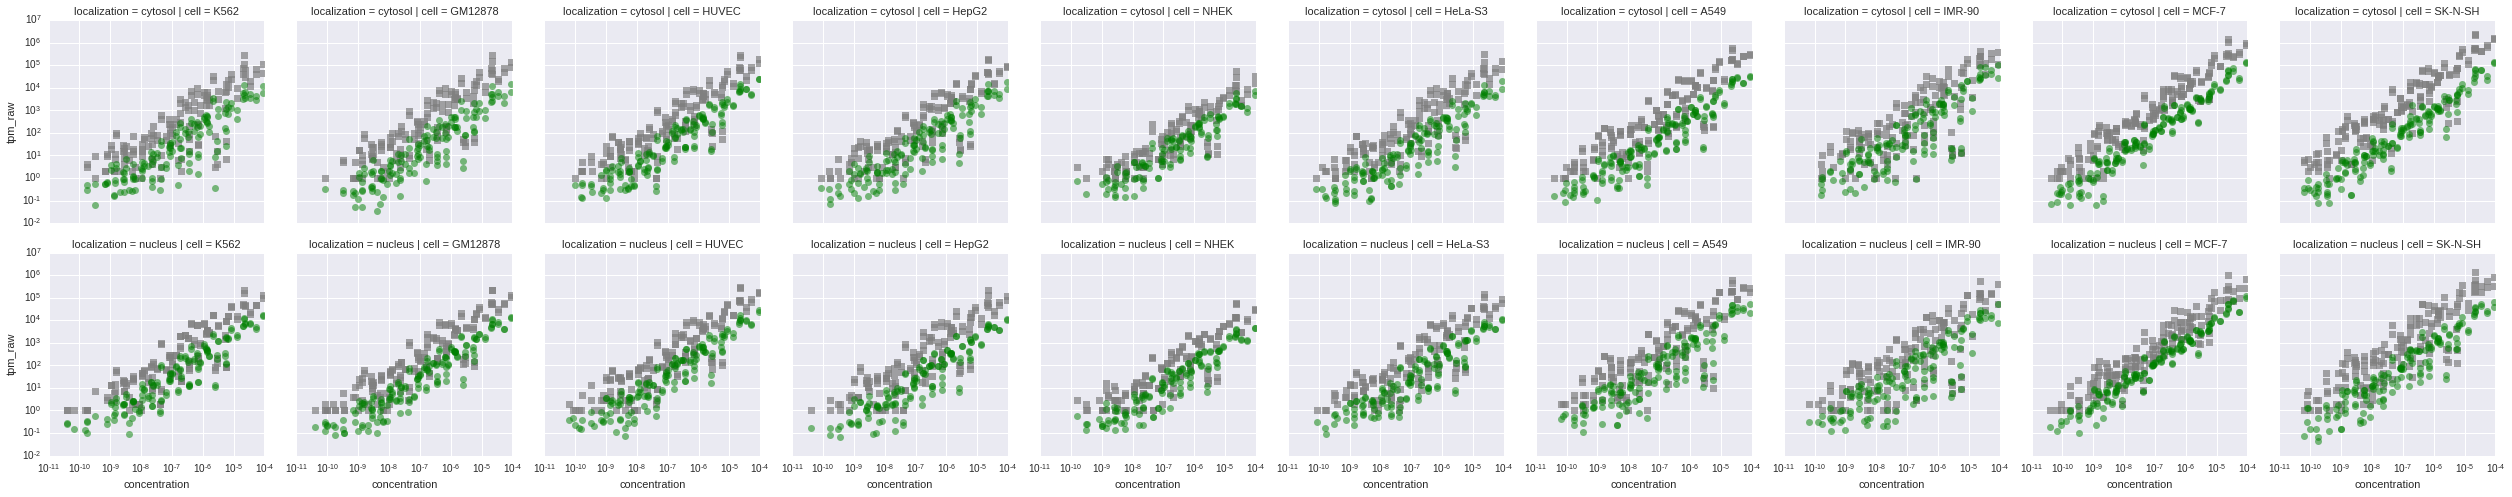

In [138]:
grid = sns.FacetGrid(df, col="cell", row="localization", size=3.5, aspect=1)
grid.map(plt.loglog, "concentration", "est_raw", ls='None', color="grey", marker="s", alpha=0.7)
grid.map(plt.loglog, "concentration", "tpm_raw", ls='None', color="green" ,marker="o", alpha=0.5)

### Comparison of sleuth normalized tpm and est for each cell line and localization

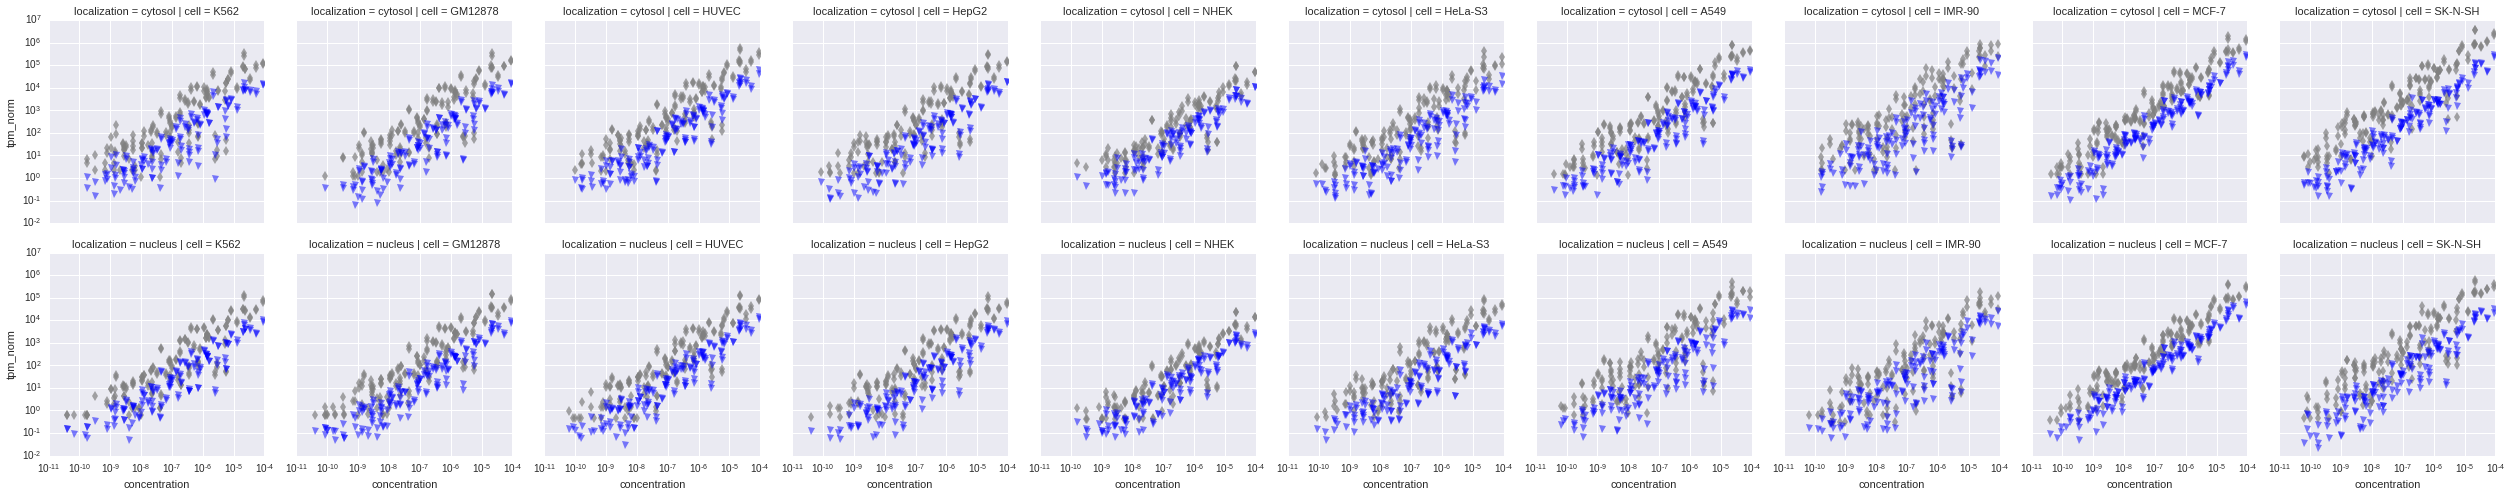

In [135]:
grid = sns.FacetGrid(df, col="cell", row="localization", size=3.5, aspect=1)
grid.map(plt.loglog, "concentration", "est_norm", ls='None', color="grey", marker="d", alpha=0.7)
grid.map(plt.loglog, "concentration", "tpm_norm", ls='None', color="blue" ,marker="v", alpha=0.5)

### Comparison of kallisto raw tpm versus sleuth normalized tpm relative to the initial spike concentrations

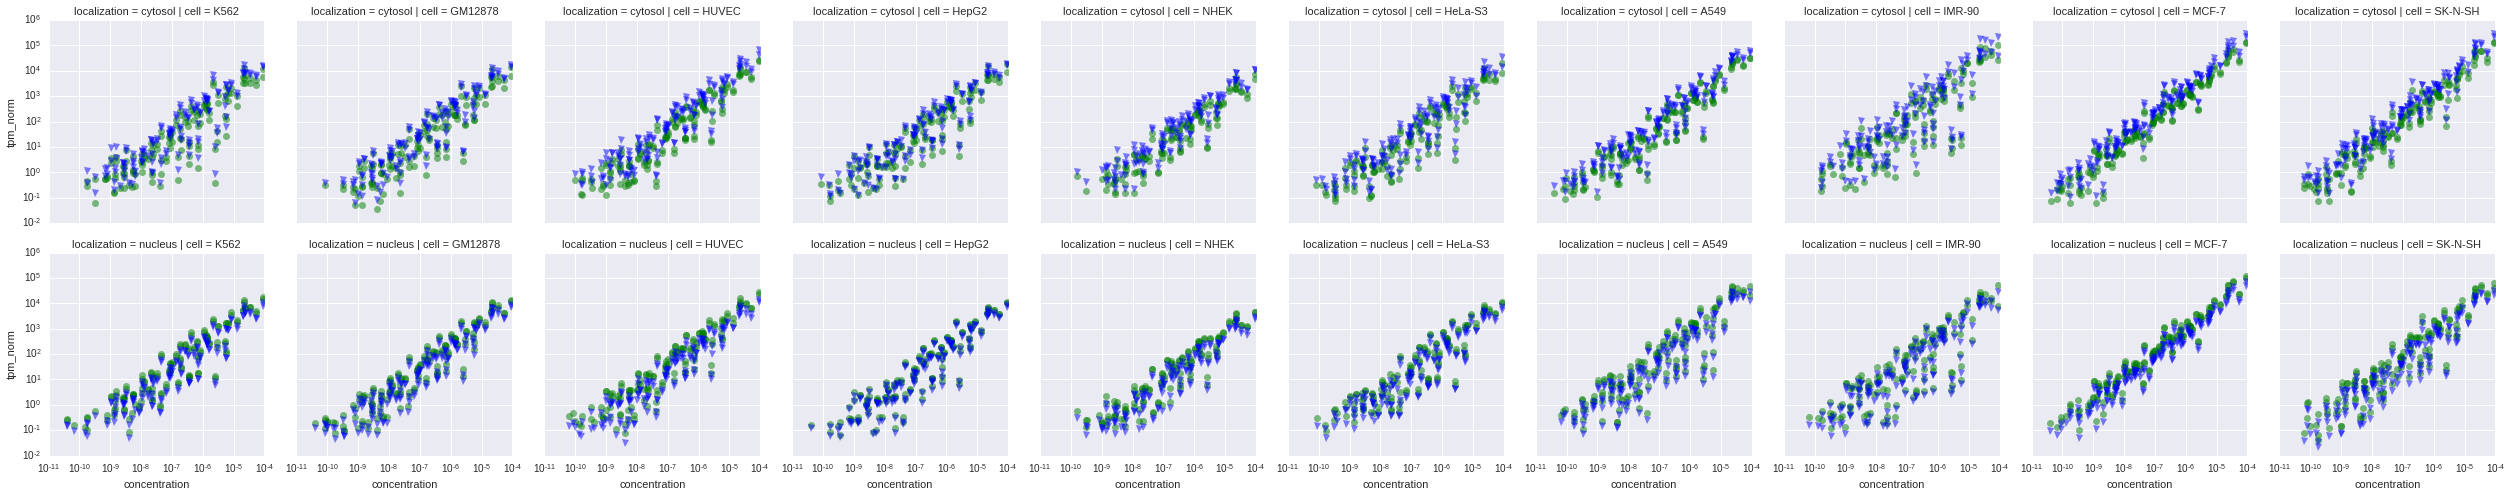

In [139]:
grid = sns.FacetGrid(df, col="cell", row="localization", size=3.5, aspect=1)
grid.map(plt.loglog, "concentration", "tpm_raw", ls='None', color="green" ,marker="o", alpha=0.5)
grid.map(plt.loglog, "concentration", "tpm_norm", ls='None', color="blue" ,marker="v", alpha=0.5)

**Comparison of the ERCC est and tpm after and before normalization by Sleuth**

The tpm from kalisto seems to normalization seems to do a good job since the values are more tighly packed together after. However, when comparing the tpm normalize or not by sleuth (by which way ?) we can't seem any significant improvment. The cytosol values seems to be more affected than the nuclei values. ??

### Comparison of the nuclear and cytoplasmic fractions in raw tpm relative to the initial spike concentrations

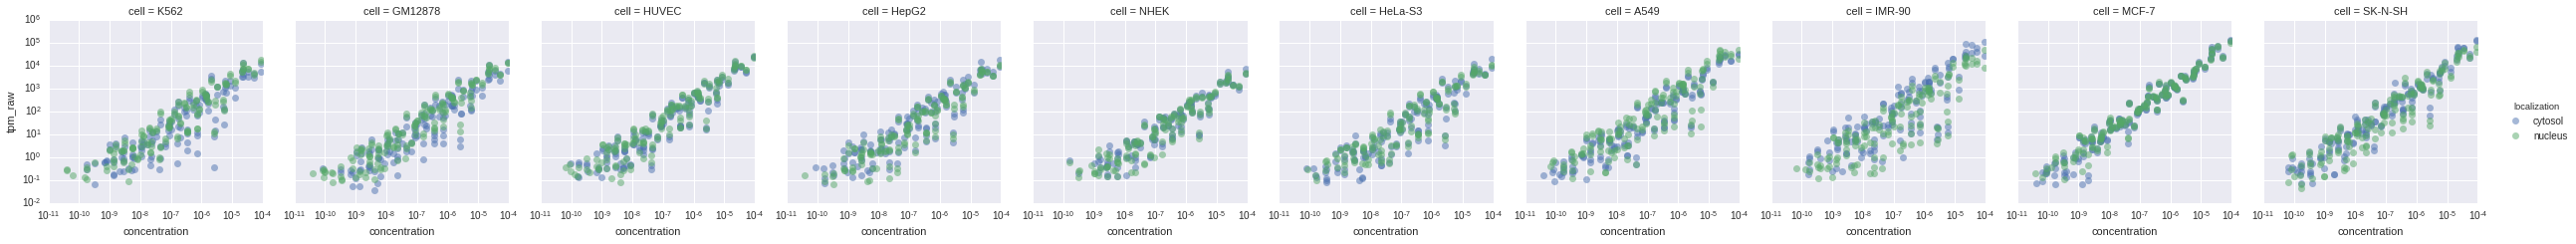

In [5]:
grid = sns.FacetGrid(df, col="cell", hue="localization", size=3.5, aspect=1, col_wrap=10)
grid.map(plt.loglog, "concentration", "tpm_raw", ls='None', marker="o", alpha=0.5)
grid.add_legend()

### Comparison of the nuclear and cytoplasmic fractions in normalized tpm relative to the initial spike concentrations

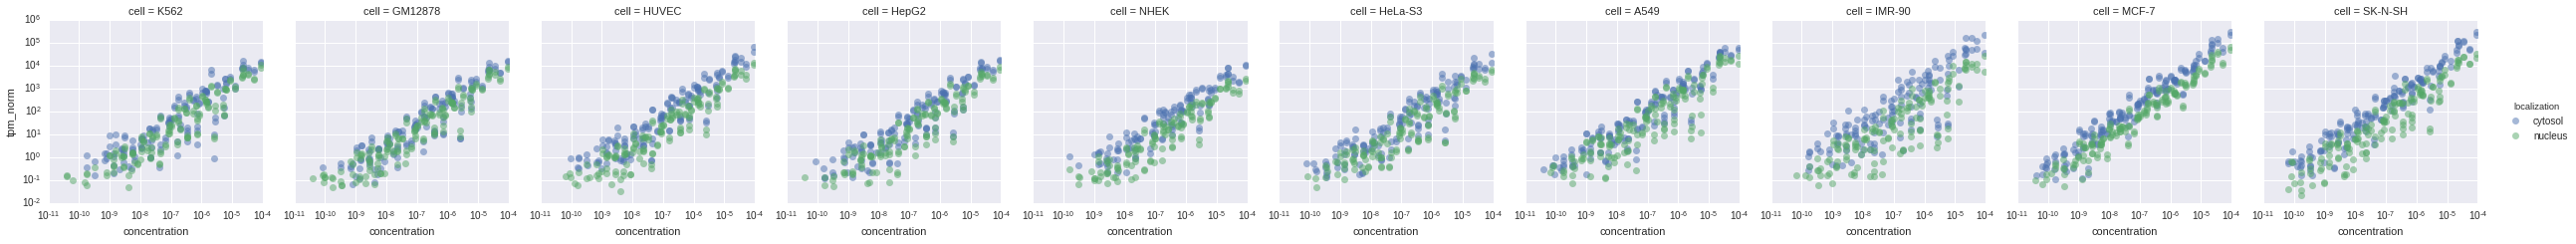

In [6]:
grid = sns.FacetGrid(df, col="cell", hue="localization", size=3.5, aspect=1, col_wrap=10)
grid.map(plt.loglog, "concentration", "tpm_norm", ls='None', marker="o", alpha=0.5)
grid.add_legend()

### Direct comparison of tpm before and after normalizationin the nuclus and cytoplasm

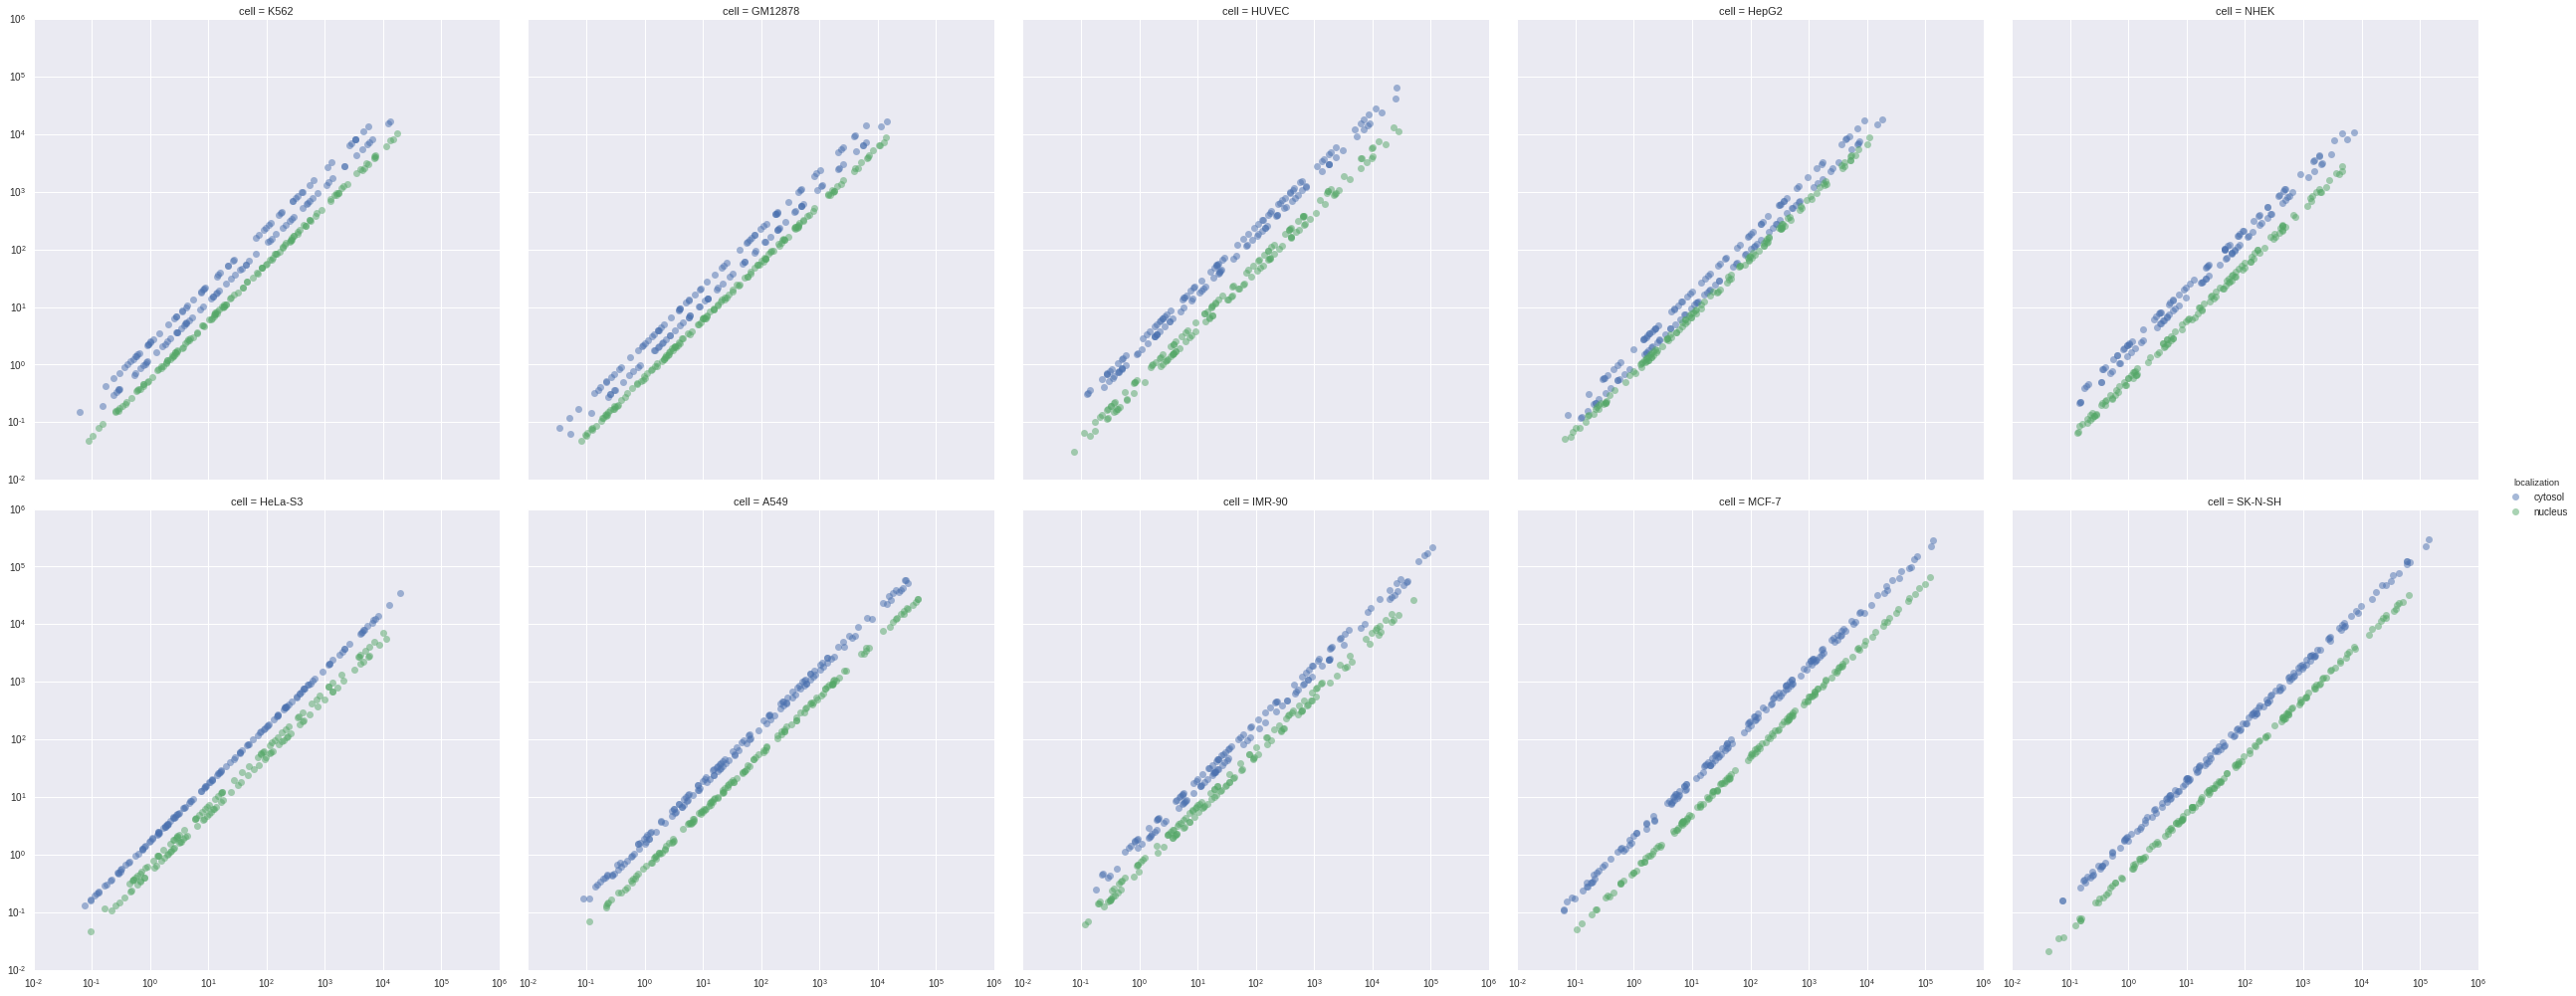

In [23]:
grid = sns.FacetGrid(df, col="cell", hue="localization", size=7, aspect=1, col_wrap=5)
grid.map(plt.loglog, "tpm_raw", "tpm_norm", ls='None', marker="o", alpha=0.5)
grid.add_legend()

**Apparently the normalization algorithm of Sleuth is not doing a goodd job with the datasets. Indeed, instead of improving the variability between the replicates and the proximity of both nucleus and cytoplasm it increases the difference **

**=> To do = TRY TO PLOT NUCLEUS VS CYTO TPM BEFORE AND AFTER NORM**  